# MLP Project (T2 2023) by Ganesh P  

`Disclaimer`   

> This final notebook contains only the most relevant code to show the path/flow of my project work over few weeks. Rest of the code is in [my github repo](https://github.com/ganeshbmc/MLP_project) which is private at present (I will make it public after the project is over).  

`Strengths`  

> * Modular code (DRY principle)  
> * End to end pipeline in one function (with helper functions)   

`Overview`  

`PART I`  

1.	> Screen the datasets and import them.  
2.	> Perform EDA (first round).
3.	> Data cleaning.
4.	> Basic models including dummy model.
5.	> Because this is a text sentiment analysis project, focus on 'reviewText' column, work on cleaning text data and vectorising/tokenising it, build several models till the best possible score is reached.  

`PART II`  

6.	> Merge train and movies dataset.
7.	> Perform EDA (second round) on merged dataset.
8.	> Data cleaning.
9.	> Build models on merged dataset.
10.	> Understand the results and do another round of EDA if needed.
11.	> Build final model.  

`PART III (After project window closes)`  

12. > Use NLTK library for further processing text data.  
13. > Try to address comments from different languages, special characters etc.  
14. > Try imblearn library to address class imbalance.  
15. > Try to use currently available LLMs and see how my model performs agains them.  

`Default code on Kaggle notebook`  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


### Specify platform  

In [2]:
platform = 'kaggle'  

### Import libraries  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import compress

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier

# import lightgbm as ltb

import scipy.stats as stats
print("Imports done.")

Imports done.


# PART I  

## Load datasets  

In [4]:
if platform == 'vscode':
    traindf = pd.read_csv("data/train.csv")
else:
    traindf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
    
traindf.shape

(162758, 5)

In [5]:
if platform == 'vscode':
    testdf = pd.read_csv("data/test.csv")
else:
    testdf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

testdf.shape

(55315, 4)

### Understanding the data and getting it ready for training and evaluating models  


In [6]:
traindf.shape

(162758, 5)

In [7]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [8]:
traindf.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

### Fill empty reviewText with custom text  

In [9]:
traindf["reviewText"].fillna("empty", inplace=True)
traindf.isna().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
dtype: int64

## EDA  


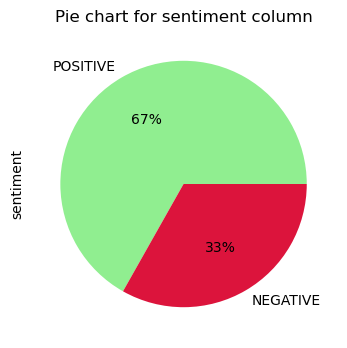

In [10]:
# Pie chart for sentiment column
plt.figure(figsize=(6, 4))
traindf["sentiment"].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["lightgreen", "crimson"])
plt.title("Pie chart for sentiment column")
plt.show()

In [11]:
# Chi-square test for isFrequentReviewer column and sentiment column   

contingency_table = pd.crosstab(traindf['isFrequentReviewer'], traindf['sentiment'])
print(contingency_table)
stats.chi2_contingency(contingency_table)

sentiment           NEGATIVE  POSITIVE
isFrequentReviewer                    
False                  35760     77429
True                   18237     31332


Chi2ContingencyResult(statistic=419.89235425657796, pvalue=2.5755894769493255e-93, dof=1, expected_freq=array([[37551.86493444, 75637.13506556],
       [16445.13506556, 33123.86493444]]))

### Separate features and labels  

In [12]:
train_features = traindf["reviewText"]
train_labels = traindf.iloc[:, -1]
train_features.shape, train_labels.shape

((162758,), (162758,))

### Split traindf into training and testing parts  

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((122068,), (40690,), (122068,), (40690,))

## Model evaluation plan and code  

In [14]:
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import f1_score

In [15]:
# def evaluate(y_test, y_pred):
#     print(classification_report(y_test, y_pred))
#     print(confusion_matrix(y_test, y_pred))
#     # print(f1_score(y_test, y_pred))
#     ConfusionMatrixDisplay(y_test, y_pred)
#     return

### Data preprocessing  

`Define stop words`  

In [16]:
# stop_words = ["able", "about", "above", "abst", "ac"]     # Deprecated  
# type(stop_words), len(stop_words)

## Feature extraction  

### Understand CountVectorizer and TfidfVectorizer  

In [17]:
# text = X_train.copy()
# text.head()

In [18]:
# vectorizer = TfidfVectorizer(stop_words=stop_words)
# vectorized_text = vectorizer.fit_transform(text["reviewText"])
# vectorized_text

`Without stop words`  
<122068x58624 sparse matrix of type '<class 'numpy.float64'>'
	with 2312222 stored elements in Compressed Sparse Row format>

`With stop words`  
<122068x57784 sparse matrix of type '<class 'numpy.float64'>'
	with 1188395 stored elements in Compressed Sparse Row format>   

In [19]:
# vectorizer2 = CountVectorizer(stop_words=stop_words)
# vectorized_text2 = vectorizer2.fit_transform(text["reviewText"])
# vectorized_text2

`Without stop words`  
<122068x58624 sparse matrix of type '<class 'numpy.int64'>'
	with 2312222 stored elements in Compressed Sparse Row format>

`With stop words`  
<122068x57784 sparse matrix of type '<class 'numpy.int64'>'
	with 1188395 stored elements in Compressed Sparse Row format>

### Conclusion   
`TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.`  

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## Model building workflow  

`Make pipeline for preprocesing and model training and predictions`  


In [20]:
# def preprocess_n_train(X_train, y_train, preprocessor, model):
#     pipe = Pipeline(steps=[
#                             ("preprocessor", preprocessor),
#                             ("model", model)
#                         ])
    
#     pipe.fit(X_train, y_train)

#     print("Given model has been trained. Use predict method to get predictions array.")
#     return pipe


# def predict_n_evaluate(pipeline, X_test, y_test):
#     y_pred = pipeline.predict(X_test)
#     print(f"y_pred shape: {y_pred.shape}")
#     print(f"Summary of predictions: {np.unique(y_pred, return_counts=True)}")
#     print(classification_report(y_test, y_pred))
#     print(confusion_matrix(y_test, y_pred))
#     return y_pred

## Building 3 basic models  

### Text preprocessors  

In [21]:
# tvec = TfidfVectorizer()
# cvec = CountVectorizer()        # Note that TfidfVectorizer and CountVectorizer+TfidsTransformer do the same function
# tvec, cvec

### Logistic Regression with TfidVectorizer for preprocessing  

In [22]:
# logreg = LogisticRegression(max_iter=1000)
# logreg_pipe = preprocess_n_train(X_train, y_train, tvec, logreg)
# y_pred_logreg = predict_n_evaluate(logreg_pipe, X_test, y_test)
# y_pred_logreg

### SVM model  

In [23]:
# svm = LinearSVC()
# svm_pipe = preprocess_n_train(X_train, y_train, tvec, svm)
# y_pred_svm = predict_n_evaluate(svm_pipe, X_test, y_test)
# y_pred_svm

### Naive Bayes model  

#### MultinomialNB  

In [24]:
# mnb = MultinomialNB()
# mnb_pipe = preprocess_n_train(X_train, y_train, tvec, mnb)
# y_pred_mnb = predict_n_evaluate(mnb_pipe, X_test, y_test)
# y_pred_mnb

## Submitting predictions to Kaggle competition  

In [25]:
# def submit(selected_model=logreg, selected_preprocessor=tvec):
    
#     # Retrain on the whole train.csv file  
#     traindf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
#     X_train = traindf["reviewText"]
#     X_train.fillna("empty", inplace=True)
#     y_train = traindf["sentiment"]
#     pipe = preprocess_n_train(X_train, y_train, selected_preprocessor, selected_model)
    
#     # Predict on test.csv file
#     testdf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
#     X_test = testdf["reviewText"]
#     X_test.fillna("empty", inplace=True)
    
#     y_pred = pipe.predict(X_test)
    
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.to_csv("submission.csv")
    
#     return "Successfully created the submission file!!!"

In [26]:
# submit(logreg_cv1, tvec_cv1)

# PART II  

## Merge "movies.csv" with "train.csv" and "test.csv"  

### Helper functions  

In [27]:
# Helper function for loading files  

def load_csv(filename: str):
    if platform == "vscode":
        df = pd.read_csv(f"data/{filename}.csv")
    else:
        df = pd.read_csv(f"/kaggle/input/sentiment-prediction-on-movie-reviews/{filename}.csv")
        
    return df

In [28]:
def inspect(df: pd.DataFrame):
    print(f"Shape of the dataframe: {df.shape}")
    print()
    print(f"Columns in the dataframe:\n{df.columns}")
    print()
    print(f"{df.info()}")
    print()
    # print(f"Summary: {df.describe()}")
    print(f"Missing values:\n{df.isna().sum()}")
    return

In [29]:
def name_fl(name):
    l = name.split()
    n = ' '.join((l[0], l[-1]))
    return n

In [30]:
def select_features(df: pd.DataFrame, moviesdf: pd.DataFrame, row_thresh_null=None):
    '''
    This function merges the given dataframes. Note that the first df must be "train" or "test" and
    the second df should be "movies".
    Note: Sentiment column is present only in "train.csv" file and not "test.csv" file.
    '''
    
    # Drop duplicates from moviesdf
#     movies_unique = moviesdf.drop_duplicates(subset=["movieid"])

    # Drop duplicates using groupby - clubs similar rows and fills in missing values better
    movies_unique = moviesdf.fillna(value=np.nan).groupby("movieid").first().reset_index()
    

    # Handle missing values in movies.csv better than just dropping duplicates?
#     movies_unique = moviesdf.copy()
#     movies_unique[["audienceScore", "runtimeMinutes"]] = movies_unique[["audienceScore", "runtimeMinutes"]].interpolate(method='linear', axis=0)
#     movies_unique = movies_unique.fillna(value=np.nan).groupby("movieid").first().fillna(method='ffill').reset_index()

    

    # Merge df and movies_unique
    df_merged = pd.merge(df, movies_unique, on="movieid", how='left')
    
    # Rename "isTopCritic" column, if it exists, to "isFrequentReviewer"
    df_merged.rename(columns={"isTopCritic": "isFrequentReviewer"}, inplace=True)
    
    # Drop columns
#     df_merged = df_merged.drop(columns=["title", "ratingContents", "releaseDateTheaters", "releaseDateStreaming", "distributor", "soundType"])
#     df_merged = df_merged.drop(columns=["title", "soundType"])
    
    # Drop rows (OPTIONAL: Uses kwarg row_thresh_null)
    if row_thresh_null != None:
        df_merged.dropna(axis=0, thresh=(df_merged.shape[1] - row_thresh_null), inplace=True)
        

    # Create new columns based on reviewText
    final = df_merged.copy()
    final["reviewYN"] = np.where(final["reviewText"].isnull(), 1, 0)    # Feature engineering - adding a new column
    final["reviewWC"] = final.apply(lambda x: len(str(x["reviewText"]).split()), axis=1)    # Feature engineering - adding second new column
    
    # Clean text (replace numbers with empty string) and fill missing values in "reviewText" with empty string
    final["reviewText"] = final["reviewText"].str.replace('\d+', '', regex=True)
    final["reviewText"] = final["reviewText"].fillna("neutral")
    
    # Fill missing values in "rating", "genre", original columns with the word "unknown"
    final["rating"] = final["rating"].fillna("unknown")
    final["originalLanguage"] = final["originalLanguage"].fillna("unknown")
    final["genre"] = final["genre"].fillna("unknown")
    final["genre"] = final["genre"].apply(lambda x: re.sub(r"-", "", x))
    final["genreSorted"] = final["genre"].apply(lambda x: (",").join(sorted(x.split(", "))))
#     final["genre"] = final["genre"].replace(to_replace={"&": ""})

    # Impute missing values for "audienceScore" and "runtimeMinutes" columns
#     final["audienceScore"] = final["audienceScore"].fillna(final["audienceScore"].mean())        # MOVED
#     final["runtimeMinutes"] = final["runtimeMinutes"].fillna(final["runtimeMinutes"].median())   # MOVED
    
    # Preprocess and impute missing values in "boxOffice" column
    final["boxOffice"] = final["boxOffice"].str[1:]
    final["boxOffice"] = final["boxOffice"].replace(to_replace={"M": "*1000000", "K": "*1000"}, regex=True)
    final["boxOffice"] = final["boxOffice"].loc[final["boxOffice"].notnull()].apply(lambda x: eval(str(x)))
#     final["boxOffice"] = final["boxOffice"].fillna(final["boxOffice"].median())                  # MOVED
    # (Optional) Replace outliers in boxOffice with median
#     median = final["boxOffice"].describe()['50%']
#     iqr = final["boxOffice"].describe()['75%'] - final["boxOffice"].describe()['25%']
#     ll = median - (1.5*iqr)
#     ul = median + (1.5*iqr)
#     final.loc[final["boxOffice"] > ul, "boxOffice"] = median
    
    # Clean language names
    final["originalLanguage"].replace({"English (United Kingdom)": "English", 
                                            "English (Australia)" : "English",
                                            "French (France)": "French", 
                                            "French (Canada)": "French",
                                            "Portuguese (Brazil)": "Portuguese",
                                            "Spanish (Spain)": "Spanish"},                                         
                                            inplace=True)
    
    # Clean reviewerName column
    pre_post_fixes = {"Mr. ": "", "Mrs. ": "", "Ms. ": "", "Dr. ": "", 
                      " MD": "", " DDS": "", " DVM": "", " Jr.": "", " PhD": "", " II": "", " IV": ""}
    final["reviewerName"] = final["reviewerName"].replace(pre_post_fixes, regex=True)
    final["reviewerName"] = final["reviewerName"].apply(name_fl)
    
    # Handle 'ratingContents' column
    final["ratingContents"] = final["ratingContents"].fillna("neutral")
    final["rcSorted"] = final["ratingContents"].apply(lambda x: (",").join(sorted(x.strip("][").split(", "))))
    final["rcSorted"] = final["rcSorted"].apply(lambda x: re.sub(r"'", "", x))
    final["rcSorted"] = final["rcSorted"].apply(lambda x: re.sub(r"[/\s]", "_", x))  
    
    # Handle 'ratingContents' column
    final["distributor"] = final["distributor"].fillna("unknown")
    
    # Work with 'releaseDateTheaters', releaseDateStreaming column
    final[["releaseDateTheaters", "releaseDateStreaming"]] = final[["releaseDateTheaters", "releaseDateStreaming"]].astype('datetime64[ns]')

    final["releaseDate"] = final[["releaseDateTheaters", "releaseDateStreaming"]].min(axis=1, skipna=False)
#     final["releaseDate"] = final["releaseDate"].fillna(final["releaseDate"].median())               # MOVED

    final["releaseYear"] = final["releaseDate"].dt.year
    final["releaseMonth"] = final["releaseDate"].dt.month
    
    # Compute "releaseDiff" column and fill missing values in "releaseDiff" and (optional) replace outliers
    final["releaseDiff"] = (final["releaseDateStreaming"] - final["releaseDateTheaters"]) / np.timedelta64(1, 'D')
    final["releaseDiff"] = final["releaseDiff"].apply(lambda x: abs(x))
    final["releaseDiff"] = final["releaseDiff"].fillna(value=0)
#     final["releaseDiff"] = final["releaseDiff"].fillna(final["releaseDiff"].median())
    # median = final["releaseDiff"].describe()['50%']
    # iqr = final["releaseDiff"].describe()['75%'] - final["releaseDiff"].describe()['25%']
    # ll = median - (1.5*iqr)
    # ul = median + (1.5*iqr)
    # final.loc[final["releaseDiff"] > ul, "releaseDiff"] = median
    # final.loc[final["releaseDiff"] < ll, "releaseDiff"] = median
    
#     # Create new feature columns
    
#     # Convert audienceScore to categories  
#     num_bins_as = 20
#     final["audScoreBins"] = pd.cut(final['audienceScore'], bins=num_bins_as, labels=False)
    
#     # Convert runtimeMinutes to categories  
# #     num_bins_rt = 20
#     final["runtimeBins"] = pd.cut(final['runtimeMinutes'], bins=[0,75,120,180,565], labels=[4,3,2,1])
    
#     # Convert boxOffice to categories  
#     num_bins_bo = 5
#     final["boxOfficeBins"] = pd.cut(final['boxOffice'], bins=num_bins_bo, labels=False)
    
#     # Convert releaseDiff to categories  
#     num_bins_rd = 5
#     final["releaseDiffBins"] = pd.cut(final['releaseDiff'], bins=[-1, 180, 360, 1000, 40000], labels=[0, 1, 2, 3])

    return final

In [31]:
def split_train_predict(features, labels, pipeline, test_size=0.25, random_state=42):
    # cols = features.columns
    if len(features.shape) == 1:
        features = features.to_numpy().reshape(-1, 1)  # reshape to 2D array
    features = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return pipeline

### Merge "train.csv" file with "movies.csv" file  

In [32]:
merged = select_features(load_csv("train"), load_csv("movies"), row_thresh_null=None)

In [33]:
# inspect(merged)    # Note missing values in ['audienceScore', 'runtimeMinutes', 'boxOffice'] columns  

In [34]:
# Simple Imputer for ['audienceScore', 'runtimeMinutes', 'boxOffice'] columns
si = SimpleImputer(strategy='median')
merged[['audienceScore', 'runtimeMinutes', 'boxOffice']] = si.fit_transform(merged[['audienceScore', 'runtimeMinutes', 'boxOffice']])
si.statistics_

array([6.80e+01, 1.04e+02, 1.43e+07])

In [35]:
# Fill 'releaseDate' column with median  
merged['releaseDate'] = merged["releaseDate"].fillna(merged["releaseDate"].median())

In [36]:
# Check out 'merged' df after imputation  
inspect(merged)

Shape of the dataframe: (162758, 26)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType', 'reviewYN', 'reviewWC', 'genreSorted', 'rcSorted',
       'releaseDate', 'releaseYear', 'releaseMonth', 'releaseDiff'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   movieid               162758 non-null  object        
 1   reviewerName          162758 non-null  object        
 2   isFrequentReviewer    162758 non-null  bool          
 3   reviewText            162758 non-null  object        
 4   sentiment  

In [37]:
merged[['audienceScore', 'runtimeMinutes', 'boxOffice']].describe()

,audienceScore,runtimeMinutes,boxOffice
count,162758.000000,162758.000000,1.627580e+05
mean,65.062565,106.992019,4.160983e+07
std,19.844000,22.203778,7.932291e+07
min,0.000000,4.000000,0.000000e+00
25%,51.000000,93.000000,2.000000e+06
50%,68.000000,104.000000,1.430000e+07
75%,81.000000,118.000000,4.200000e+07
max,100.000000,561.000000,8.584000e+08


### EDA releaseDiff  

In [38]:
# abs values
merged["releaseDiff"].describe()

count    162758.000000
mean       1653.469015
std        4581.420922
min           0.000000
25%          65.000000
50%         116.000000
75%         375.000000
max       38922.000000
Name: releaseDiff, dtype: float64

In [39]:
# merged['releaseDiffBins'].value_counts()

<Axes: xlabel='sentiment', ylabel='releaseDiff'>

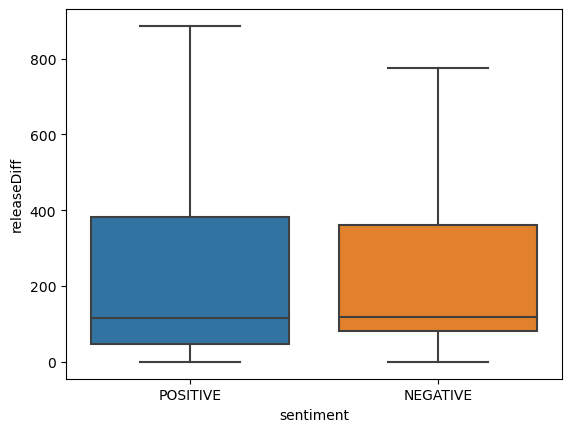

In [40]:
sns.boxplot(x=merged['sentiment'], y=merged['releaseDiff'], showfliers=False)

In [41]:
# sns.displot(merged['releaseDiffBins'])

In [42]:
# merged['sentiment'].loc[merged['releaseDiffBins'] > 0].value_counts()

In [43]:
# merged['releaseDiffBins'].describe()

### EDA 'distributor'  

In [44]:
merged["distributor"].value_counts()

unknown                              20489
Universal Pictures                    8847
Warner Bros. Pictures                 8722
Paramount Pictures                    7773
20th Century Fox                      7007
                                     ...  
Almi Pictures                            1
Koch Lorber                              1
Magic Lamp                               1
Fine Line Features, Miramax Films        1
American Film Co.                        1
Name: distributor, Length: 1796, dtype: int64

In [45]:
merged["runtimeMinutes"].describe()

count    162758.000000
mean        106.992019
std          22.203778
min           4.000000
25%          93.000000
50%         104.000000
75%         118.000000
max         561.000000
Name: runtimeMinutes, dtype: float64

<Axes: xlabel='sentiment', ylabel='runtimeMinutes'>

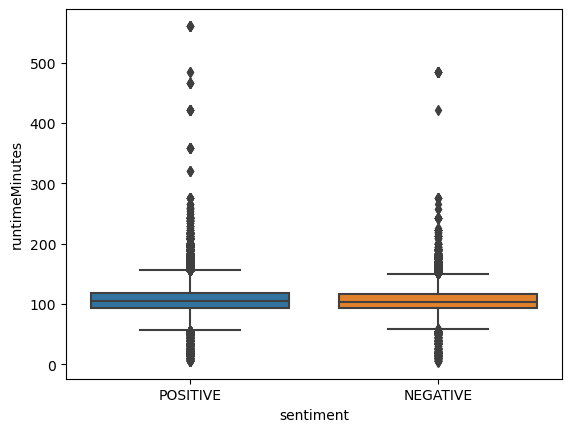

In [46]:
sns.boxplot(y=merged["runtimeMinutes"], x=merged["sentiment"])

In [47]:
# print(merged["boxOfficeBins"].value_counts())
# sns.displot(merged["boxOfficeBins"])

In [48]:
merged["reviewText"].head()

0    Henry Selick’s first movie since ’s Coraline. ...
1    With a cast that reads like the Vogue Oscar pa...
2    Creed II does not give us anything but another...
3    I know what you're thinking, but this is no Li...
4    Director Fernando Meirelles tells the story wi...
Name: reviewText, dtype: object

In [49]:
merged["reviewYN"].sum()

6447

In [50]:
merged["reviewWC"].head()

0    11
1    24
2    22
3    34
4    20
Name: reviewWC, dtype: int64

In [51]:
merged["reviewWC"].describe()

count    162758.000000
mean         21.013707
std          10.216532
min           1.000000
25%          14.000000
50%          21.000000
75%          28.000000
max          54.000000
Name: reviewWC, dtype: float64

<Axes: xlabel='reviewWC', ylabel='Count'>

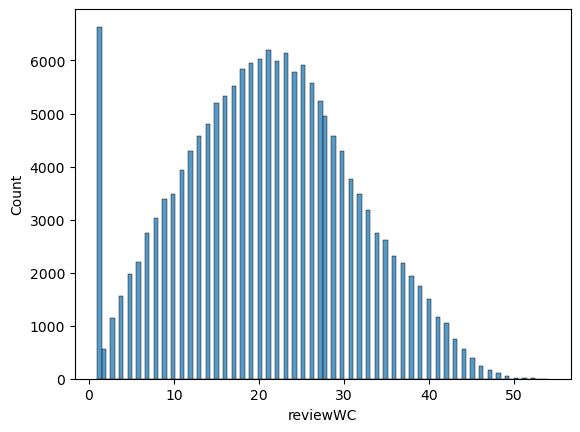

In [52]:
sns.histplot(merged["reviewWC"])

In [53]:
merged['rating'].value_counts()

R          60248
unknown    44587
PG-13      42697
PG         13669
TV14         947
NC-17        285
TVPG         281
TVMA          44
Name: rating, dtype: int64

In [54]:
merged['isFrequentReviewer'].value_counts()

False    113189
True      49569
Name: isFrequentReviewer, dtype: int64

In [55]:
merged["reviewerName"].head()

0      Benjamin Henry
1       Felicia Lopez
2     Charles Burgess
3        Ryan Barrett
4    Alexander Glover
Name: reviewerName, dtype: object

In [56]:
merged['boxOffice'].value_counts()

14300000.0    32327
2000000.0       922
1100000.0       891
1000000.0       834
1200000.0       802
              ...  
58500.0           1
500800.0          1
265600.0          1
292500.0          1
799400.0          1
Name: boxOffice, Length: 3819, dtype: int64

In [57]:
# Check correlation between 'boxOffice' and ''sentiment'
# bo_df = merged.copy()
# print(bo_df["boxOffice"])
# bo_df["boxOffice"] = bo_df["boxOffice"].str[1:]
# bo_df["boxOffice"] = bo_df["boxOffice"].replace(to_replace={"M": "*1000000", "K": "*1000"}, regex=True)
# bo_df["boxOffice"] = bo_df["boxOffice"].loc[bo_df["boxOffice"].notnull()].apply(lambda x: eval(str(x)))
# bo_df["boxOffice"] = bo_df["boxOffice"].fillna(bo_df["boxOffice"].median())
# bo_df["boxOffice"].describe()

In [58]:
# median = bo_df["boxOffice"].describe()['50%']
# iqr = bo_df["boxOffice"].describe()['75%'] - bo_df["boxOffice"].describe()['25%']
# median, iqr

In [59]:
# ll = median - (1.5*iqr)
# ul = median + (1.5*iqr)
# ll, ul

In [60]:
# bo_df["boxOffice"].mean()

In [61]:
# bo_df.loc[bo_df["boxOffice"] > ul, "boxOffice"] = median
# bo_df["boxOffice"].mean()

In [62]:
# bo_df["boxOffice"].min(), bo_df["boxOffice"].max()

In [63]:
# sns.boxplot(x="sentiment", y="boxOffice", data=bo_df, showfliers = False)

## EDA  

### An interesting finding through exploration  
  
* OHE and TfidfVectorizer on director column give the same result when ngram_range(2,2) is used (see code below)!

In [64]:
# Compare OHE and TfidfVectorizer on director column

dirs = merged["director"].copy()
print(dirs.shape)
dirs_uniq = merged["director"].unique()
print(len(dirs_uniq))

du_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit_transform(dirs.to_numpy().reshape(-1, 1))
print(du_ohe.shape, type(du_ohe))

dirs_2 = merged["director"].copy()
print(dirs_2.shape)
du_tfidf = TfidfVectorizer(ngram_range=(2,2)).fit_transform(dirs_2).toarray()
print(du_tfidf.shape, type(du_tfidf))

print(np.array_equal(du_ohe, du_tfidf))

(162758,)
9476
(162758, 9476) <class 'numpy.ndarray'>
(162758,)
(162758, 9476) <class 'numpy.ndarray'>
True


In [65]:
print(dirs.head())
d = dirs.copy()
d["name_len"] = d.apply(lambda x: len(x.split()))
d["name_len"].value_counts()

0       Bennie Basso
1         Alma White
2       Bobby Oleary
3    Eric Hutcherson
4         John Trent
Name: director, dtype: object


2    162758
Name: director, dtype: int64

In [66]:
# Compare OHE and TfidfVectorizer on reviewerName column
# Note: reviewerName column has salutations like "Mr. " etc, and some names appear middle names. Therefore needs cleaning

# def name_fl(name):
#     l = name.split()
#     n = ' '.join((l[0], l[-1]))
#     return n

# reviewers = merged["reviewerName"].copy()
# reviewers = pd.DataFrame(reviewers)
# reviewers = reviewers.replace({"Mr. ": "", "Mrs. ": ""}, regex=True)
# reviewers["reviewerName"] = reviewers["reviewerName"].apply(name_fl)
# print(reviewers.shape)

# reviewers_uniq = merged["reviewerName"].unique()
# print(len(reviewers_uniq))

# reviewers_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit_transform(reviewers.to_numpy().reshape(-1, 1))
# print(reviewers_ohe.shape, type(reviewers_ohe))

# reviewers_2 = merged["reviewerName"].copy()
# reviewers_2 = pd.DataFrame(reviewers_2)
# print(reviewers_2.head())
# reviewers_2 = reviewers_2.replace({"Mr. ": "", "Mrs. ": ""}, regex=True)
# reviewers_2["reviewerName"] = reviewers_2["reviewerName"].apply(name_fl)
# reviewers_2 = reviewers_2.squeeze()
# print(reviewers_2.shape)
# print(reviewers_2.head())

# reviewers_tfidf = TfidfVectorizer(ngram_range=(2,2)).fit_transform(reviewers_2).toarray()
# print(reviewers_tfidf.shape, type(reviewers_tfidf))

# print(np.array_equal(reviewers_ohe, reviewers_tfidf))

In [67]:
# def name_fl(name):
#     l = name.split()
#     n = ' '.join((l[0], l[-1]))
#     return n

In [68]:
# print(reviewers.head())
# r = pd.DataFrame(reviewers.copy())
# r["reviewerName"] = r["reviewerName"].apply(name_fl)
# r["name_len"] = r["reviewerName"].apply(lambda x: len(x.split()))
# print(r.shape)
# print(r.head())
# print(r['name_len'].value_counts())

In [69]:
## Box plot audienceScore and sentiment  
# plt.figure(figsize=(6, 4))
# sns.boxplot(x="sentiment", y="audienceScore", data=merged, width=0.3)
# plt.title("Box plot audienceScore and sentiment")
# plt.show()

In [70]:
## Box plot runtimeMinutes and sentiment  
# plt.figure(figsize=(6, 4))
# sns.boxplot(x="sentiment", y="runtimeMinutes", data=merged, width=0.3)
# plt.title("Box plot runtimeMinutes and sentiment")
# plt.show()

In [71]:
## Column chart for sentiment and rating columns
# plt.figure(figsize=(6, 4))
# sns.countplot(x="sentiment", hue="rating", data=merged)
# plt.title("Column chart for sentiment and rating columns")
# plt.show()

In [72]:
# Correlation heatmap  
# plt.figure(figsize=(10, 8))
# sns.heatmap(merged.corr(), annot=True, cmap="coolwarm")
# plt.title("Correlation heatmap")
# plt.show()

## Merge and preprocess "test.csv" and "movies.csv" files  

In [73]:
# Merge test and movies  
merged_test = select_features(load_csv("test"), load_csv("movies"))

In [74]:
# inspect(merged_test)      # Note the missing values in ['audienceScore', 'runtimeMinutes', 'boxOffice']

In [75]:
# Transform ['audienceScore', 'runtimeMinutes', 'boxOffice'] columns in merged_test using 'si' fitted on 'merged' df  
merged_test[['audienceScore', 'runtimeMinutes', 'boxOffice']] = si.transform(merged_test[['audienceScore', 'runtimeMinutes', 'boxOffice']])
si.statistics_

array([6.80e+01, 1.04e+02, 1.43e+07])

In [76]:
# Fill 'releaseDate' column in 'merged_test' df with median from the train (merged) df  
merged_test['releaseDate'] = merged_test["releaseDate"].fillna(merged["releaseDate"].median())

In [77]:
# After transforming merged_test  
inspect(merged_test)

Shape of the dataframe: (55315, 25)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText', 'title',
       'audienceScore', 'rating', 'ratingContents', 'releaseDateTheaters',
       'releaseDateStreaming', 'runtimeMinutes', 'genre', 'originalLanguage',
       'director', 'boxOffice', 'distributor', 'soundType', 'reviewYN',
       'reviewWC', 'genreSorted', 'rcSorted', 'releaseDate', 'releaseYear',
       'releaseMonth', 'releaseDiff'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movieid               55315 non-null  object        
 1   reviewerName          55315 non-null  object        
 2   isFrequentReviewer    55315 non-null  bool          
 3   reviewText            55315 non-null  object        
 4   title                 55315 non-n

In [78]:
print(merged_test["reviewYN"].sum())
print(merged_test["reviewYN"].sum() * 100 / merged_test.shape[0])

2510
4.537648015908886


In [79]:
merged_test['rating'].value_counts()

R          18934
unknown    18386
PG-13      13220
PG          4200
TV14         333
TVPG         109
NC-17        108
TVMA          25
Name: rating, dtype: int64

In [80]:
merged_test['isFrequentReviewer'].value_counts()

False    38428
True     16887
Name: isFrequentReviewer, dtype: int64

In [81]:
merged_test['boxOffice'].value_counts()

14300000.0    13593
1100000.0       311
1000000.0       272
1300000.0       263
2000000.0       256
              ...  
200400.0          1
23800000.0        1
111200.0          1
277800.0          1
100600.0          1
Name: boxOffice, Length: 3816, dtype: int64

## Work on vocabulary  

`Build vocabulary from 'reviewText' column`  

In [82]:
rt_senti = merged[["reviewText", "sentiment"]].copy()
rt_senti.shape, rt_senti.head()

((162758, 2),
                                           reviewText sentiment
 0  Henry Selick’s first movie since ’s Coraline. ...  POSITIVE
 1  With a cast that reads like the Vogue Oscar pa...  NEGATIVE
 2  Creed II does not give us anything but another...  POSITIVE
 3  I know what you're thinking, but this is no Li...  POSITIVE
 4  Director Fernando Meirelles tells the story wi...  POSITIVE)

In [83]:
rt_test = pd.DataFrame(merged_test["reviewText"].copy())
rt_test.shape, rt_test.head()

((55315, 1),
                                           reviewText
 0  Green slowly cranks up the dread with style an...
 1  Philip Noyce's direction is elegant and unforc...
 2  It wouldn't do to say what path Maria ultimate...
 3  Pig is not exactly the arthouse John Wick that...
 4  An imaginative no-budget musical of sorts abou...)

In [84]:
def get_vocab(text_df, ngram_range=(1,1)):
    print(f"Generating vocabulary for ngram_range: {ngram_range}...")
    tvec1 = CountVectorizer(ngram_range=ngram_range, stop_words='english', strip_accents='unicode')
    tvec1.fit(text_df)
    voc_ngram = set(tvec1.vocabulary_.keys())
    return voc_ngram

In [85]:
def get_common_vocab(df_list: list, ngram_range_list: list):
    """
    Get common vocabulary from a list of dataframes.
    """
    final_common_vocab = set()
    # Get vocabulary from each dataframe for a given ngram-range
    for ngram_range in ngram_range_list:
        vocab_ngram = set()
        for num, df in enumerate(df_list, start=1):
            print(f"Working on DF#{num} in the list of DFs provided")
            vocab_ngram_df = set(get_vocab(df['reviewText'], ngram_range))
            print(f"Vocabulary size for ngram-range {ngram_range} in DF#{num}: {len(vocab_ngram_df)}\n")
            if len(vocab_ngram) > 0:
                print(f"Keeping only the common (intersection) words for ngram-range {ngram_range}...")
                vocab_ngram = vocab_ngram.intersection(vocab_ngram_df)
            else:
                print(f"Words from the first df for ngram-range {ngram_range} added.\n")
                vocab_ngram = vocab_ngram_df
        print(f"Common vocabulary for ngram-range {ngram_range}: {len(vocab_ngram)}\n")
        
        if len(final_common_vocab) > 0:
            print(f"Fusing (union) with final common vocabulary: ngram-range = {ngram_range}.\n")
            final_common_vocab = final_common_vocab.union(vocab_ngram)
        else:
            print(f"Appended first time to final common vocabulary: ngram-range = {ngram_range}.\n")
            final_common_vocab = vocab_ngram
    return final_common_vocab

In [86]:
# voc_1gram = get_vocab(rt_senti["reviewText"], ngram_range=(1,1))
# len(voc_1gram), voc_1gram[:10]

In [87]:
# voc_2gram = get_vocab(rt_senti["reviewText"], ngram_range=(2,2))
# len(voc_2gram), voc_2gram[:10]

In [88]:
# voc_3gram = get_vocab(rt_senti["reviewText"], ngram_range=(3,3))
# len(voc_3gram), voc_3gram[:10]

In [89]:
# common_unigrams = get_common_vocab([rt_senti, rt_test], ngram_range_list=[(1,1)])
# print(len(common_unigrams))
# # sorted(list(common_unigrams))

In [90]:
# common_bigrams = get_common_vocab([rt_senti, rt_test], ngram_range_list=[(2,2)])
# print(len(common_bigrams))
# # # common_bigrams

In [91]:
# common_1_2_grams = get_common_vocab([rt_senti, rt_test], ngram_range_list=[(1,1), (2,2)])
# print(len(common_1_2_grams))
# # sorted(list(common_1_2_grams))

# # common_1_2_grams = common_unigrams | common_bigrams    # older code

In [92]:
# common_trigrams = get_common_vocab([rt_senti, rt_test], ngram_range_list=[(3,3)])
# print(len(common_trigrams))
# # common_trigrams

In [93]:
# common_1_2_3_grams = get_common_vocab([rt_senti, rt_test], ngram_range_list=[(1,1), (2,2), (3,3)])
# print(len(common_1_2_3_grams))
# # sorted((common_1_2_3_grams))

# # common_1_2_3_grams = common_unigrams | common_bigrams | common_trigrams    # Older code  

### Find common vocabulary between text with positive and negative sentiments in training dataset  

In [94]:
# Dataframe for positive sentiment
rt_senti_pos = rt_senti.loc[rt_senti['sentiment'] == 'POSITIVE'].copy()
rt_senti_pos.shape

(108761, 2)

In [95]:
# Dataframe for negative sentiment
rt_senti_neg = rt_senti.loc[rt_senti['sentiment'] == 'NEGATIVE'].copy()
rt_senti_neg.shape

(53997, 2)

In [96]:
# Generate stop words/phrases specific for this project data  

# common_1_2_3_grams_sentiment = get_common_vocab([rt_senti_pos, rt_senti_neg], ngram_range_list=[(1,1), (2,2), (3,3)])
# print(len(common_1_2_3_grams_sentiment))
# # sorted(list(common_1_2_3_grams_sentiment))

In [97]:
# Generate and store the entire vocabulary of training data  

# train_1_2_3_grams = get_vocab(rt_senti['reviewText'], ngram_range=(1,3))
# print(len(train_1_2_3_grams))
# # sorted(train_1_2_3_grams)

In [98]:
# type(train_1_2_3_grams)

In [99]:
# Get the vocabulary that should be used in the final models  
# relevant_vocab = train_1_2_3_grams - common_1_2_3_grams_sentiment
# print(len(relevant_vocab))

## Submit_v4 for merged file models  

### More Helper functions  

In [100]:
# Testing predictions on missing reviewtext columns  

def predict_on_missing_review_data(pipe, selected_features, merged_train):
    missing_reviews_train = merged_train.loc[merged_train['reviewYN'] == 1]
    missing_reviews_train.reset_index(drop=True)
    X_train_miss_revs = missing_reviews_train.drop('sentiment', axis = 1)
    X_train_miss_revs = X_train_miss_revs[selected_features]
    y_train_miss_revs = missing_reviews_train['sentiment']
    
    y_pred_miss_revs = pipe.predict(X_train_miss_revs)
#     print('Predictions on rows which had missing reviewText')
    print("Confusion matrix and f1-score for rows which have no reviewText in X_train: ")
    print(confusion_matrix(y_train_miss_revs, y_pred_miss_revs, labels=pipe.classes_))
    
    return f1_score(y_train_miss_revs, y_pred_miss_revs, average='micro')

In [101]:
# Function to build pipelines for GridSearchCV which goes into the final 'submit' function  
def build_pipeline(selected_model=LogisticRegression(), 
                   selected_features={'txt': ['reviewText']}, 
                   param_grid=None,
                   vocab=None,
                   vocab_usage='tfidf',
                   strip_accents='unicode', 
                   add_countvec=False):
    # Encoders  
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    MMscaler = MinMaxScaler()
    StdScaler = StandardScaler()
    RobScaler = RobustScaler()
    
    # Text features ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']
    tfidf_vec = TfidfVectorizer(ngram_range=(1,2))
    count_vec = CountVectorizer(ngram_range=(1,2))
    txt_pipe = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(1,3), strip_accents=strip_accents))    # Adjust ngram_range here for reviewText
                        ])
    txt_pipe_vocab = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(1,3), strip_accents=strip_accents, vocabulary=vocab))    # Adjust ngram_range here for reviewText
                        ])
    txt_pipe_2 = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(2,2)))
                        ])
    txt_pipe_3 = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(1,1)))
                        ])
    txt_pipe_4 = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(1,3)))    # Adjust ngram_range here for reviewText
                        ])
    txt_pipe_title  = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(1,5)))    # Adjust ngram_range here for reviewText
                        ])
    
    # Additional pipes for count vectorizer
    txt_pipe_countvec = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,3), strip_accents=strip_accents))    # Adjust ngram_range here for reviewText
                        ])
    txt_pipe_countvec_vocab = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,3), strip_accents=strip_accents, vocabulary=vocab))    # Adjust ngram_range here for reviewText
                        ])
    
    txt_pipe_countvec_ratingContents = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,5)))    # Adjust ngram_range here for reviewText
                        ])
    txt_pipe_countvec_rcSorted = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,1)))    # Adjust ngram_range here for reviewText
                        ])
    txt_pipe_countvec_genre = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,1)))
                        ])
    txt_pipe_countvec_genreSorted = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,5)))
                        ])
    txt_pipe_countvec_distributor = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,3)))    # Adjust ngram_range here for reviewText
                        ])
    txt_pipe_countvec_title = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,5), strip_accents=strip_accents))
                        ])
    txt_pipe_countvec_movieid = Pipeline(steps=[
                            ("cvec", CountVectorizer(ngram_range=(1,1)))
                        ])
    # Basic pipes  
    TFs = []
    try:
        for c in selected_features['cat']:
            TFs.append((f"cat_{c}", ohe, [c]))
    except:
        pass
    try:
        for n in selected_features['num']:
            if n in ["runtimeMinutes", "boxOffice", "releaseDiff"]:
                TFs.append((f"num_{n}", RobScaler, [n]))
                TFs.append((f"num_{n}_ss", StdScaler, [n]))
                
            else:
                TFs.append((f"num_{n}", StdScaler, [n]))
    except:
        pass
    try:
        for t in selected_features['txt']:
            if t in ['director', 'reviewerName']:
                TFs.append((f"txt_{t}", txt_pipe_2, t))
            elif t in ["originalLanguage", "releaseYear"]:
                TFs.append((f"txt_{t}", txt_pipe_3, t))
            elif t in ['genre']:
                TFs.append((f"txt_{t}", txt_pipe_countvec_genre, t))
            elif t in ["genreSorted"]:
                TFs.append((f"txt_{t}", txt_pipe_countvec_genreSorted, t))
            elif t in ["distributor"]:
                TFs.append((f"txt_{t}", txt_pipe_countvec_distributor, t))
            elif t in ['reviewText'] and not vocab:
#                 if vocab and (vocab_usage in ["tfidf", "both"]):
#                     txt_pipe.set_params(tvec__vocabulary=vocab)
#                     txt_pipe.set_params(tvec__stop_words='english')
                TFs.append((f"txt_{t}", txt_pipe, t))
            elif t in ['reviewText_2']:
                if add_countvec:
#                     if vocab and (vocab_usage in ["count", "both"]):
#                         txt_pipe_countvec.set_params(cvec__vocabulary=vocab)
#                         txt_pipe_countvec.set_params(cvec__stop_words='english')
                    TFs.append((f"txt_{t}", txt_pipe_countvec, t))
            elif t in ['reviewText_3']:
                if vocab_usage == 'tfidf':
                    TFs.append((f"txt_{t}", txt_pipe_vocab, t))
                elif vocab_usage == 'count':
                    TFs.append((f"txt_{t}", txt_pipe_countvec_vocab, t))
            elif t in ["ratingContents"]:
                TFs.append((f"txt_{t}", txt_pipe_countvec_ratingContents, t))
            elif t in ["rcSorted"]:
                TFs.append((f"txt_{t}", txt_pipe_countvec_rcSorted, t))
            elif t in ["title"]:
                TFs.append((f"txt_{t}", txt_pipe_title, t))
            elif t in ["movieid"]:
                TFs.append((f"txt_{t}", txt_pipe_countvec_movieid, t))
            else:
                pass
    except:
        pass

    # Build ColumnTransformer  
    ct = ColumnTransformer(transformers=TFs, remainder='drop')

    # Build Pipeline
    pipe = Pipeline(steps=[('ct', ct), ('model', selected_model)])
    print("\nPipeline built successfully.")

    # Use the pipe in GridSearchCV
    if param_grid == None:
        param_grid_temp = {"model__C": [1],
                     'model__solver': ['liblinear']}
        print("Full GridSearchCV pipeline built successfully with basic default param_grid.\n")
        pipeCV = GridSearchCV(pipe, param_grid_temp, cv=10, scoring="f1_micro", n_jobs=-1)
        return pipeCV
    
    # GridSearchCV if param_grid provided
    if param_grid:
        pipeCV = GridSearchCV(pipe, param_grid, cv=10, scoring="f1_micro", n_jobs=-1)
        print("\nFull GridSearchCV pipeline built successfully.")
        return pipeCV

In [102]:
def preprocessor(imputer_type='simple'):
    
    """Preprocess train or test data. Choose 'simple' or 'knn' imputers to impute missing numerical values"""
    
    # Set imputer  
    if imputer_type == 'simple':
        imputer = SimpleImputer(strategy='median')
        print(imputer)
    elif imputer_type == 'knn':
        imputer = KNNImputer(weights='distance', n_neighbors=3)    # Adjust KNNImputer params here
        print(imputer)


    
    # Merge and preprocess train and movies data  
    merged = select_features(load_csv("train"), load_csv("movies"), row_thresh_null=None)    # Decide if you want to drop any rows containing lot of nulls
    
    # Impute missing numerical values  
    merged[['audienceScore', 'runtimeMinutes', 'boxOffice']] = imputer.fit_transform(merged[['audienceScore', 'runtimeMinutes', 'boxOffice']])
    merged['releaseDate'] = merged["releaseDate"].fillna(merged["releaseDate"].median())

    # Create new feature columns
    
    # Convert audienceScore to categories  
    num_bins_as = 20
    merged["audScoreBins"] = pd.cut(merged['audienceScore'], bins=num_bins_as, labels=False)

    # Convert runtimeMinutes to categories  
#     num_bins_rt = 20
    merged["runtimeBins"] = pd.cut(merged['runtimeMinutes'], bins=[0,75,120,180,565], labels=[4,3,2,1])
    
    # Convert boxOffice to categories  
    num_bins_bo = 5
    merged["boxOfficeBins"] = pd.cut(merged['boxOffice'], bins=num_bins_bo, labels=False)
    
    # Convert releaseDiff to categories  
    num_bins_rd = 5
    merged["releaseDiffBins"] = pd.cut(merged['releaseDiff'], bins=[-1, 180, 360, 1000, 40000], labels=[0, 1, 2, 3])
    
    # Check1 (preprocessor)
    print("\nCheck 1 (preprocessor) complete.")
    print(f"Shape of X_train: {merged.shape}")
    print(f"Features in X_train: {merged.columns}")


    
    # Merge and preprocess test and movies data  
    merged_test = select_features(load_csv("test"), load_csv("movies"))
    
    # Transform ['audienceScore', 'runtimeMinutes', 'boxOffice'] columns in merged_test using 'imputer' fitted on 'merged' df  
    merged_test[['audienceScore', 'runtimeMinutes', 'boxOffice']] = imputer.transform(merged_test[['audienceScore', 'runtimeMinutes', 'boxOffice']])
    
    # Fill 'releaseDate' column in 'merged_test' df with median from the train (merged) df  
    merged_test['releaseDate'] = merged_test["releaseDate"].fillna(merged["releaseDate"].median())

    
    # Create new feature columns
    
    # Convert audienceScore to categories  
    num_bins_as = 20
    merged_test["audScoreBins"] = pd.cut(merged_test['audienceScore'], bins=num_bins_as, labels=False)
    
    # Convert runtimeMinutes to categories  
#     num_bins_rt = 20
    merged_test["runtimeBins"] = pd.cut(merged_test['runtimeMinutes'], bins=[0,75,120,180,565], labels=[4,3,2,1])
    
    # Convert boxOffice to categories  
    num_bins_bo = 5
    merged_test["boxOfficeBins"] = pd.cut(merged_test['boxOffice'], bins=num_bins_bo, labels=False)
    
    # Convert releaseDiff to categories  
    num_bins_rd = 5
    merged_test["releaseDiffBins"] = pd.cut(merged_test['releaseDiff'], bins=[-1, 180, 360, 1000, 40000], labels=[0, 1, 2, 3])
    
    
    # Check2 (preprocessor)
    print("\nCheck 2 (preprocessor) complete.")
    print(f"Shape of X_test: {merged_test.shape}")
    print(f"Features in X_test: {merged_test.columns}")

    return merged, merged_test
    

In [103]:
# merged, merged_test = preprocessor()
# merged.shape, merged_test.shape

In [104]:
def submit_v5(classifiers= [
                {'selected_model' : LogisticRegression(C=1, solver='saga', max_iter=100000),
                 'param_grid' : None,
                 'selected_features' : {'num': ['audienceScore']},
                 'vocab' : None,
                 'vocab_usage' : 'tfidf',
                 'strip_accents' : 'unicode',
                 'add_countvec' : False}
              ], 
            imputer_type='simple'
            ):
    
    """Takes a list of dictionaries each with same keys as mentioned in the default dictionary in function definition"""
    
    print("\nRunning the submit_v5 function...")
    
    print(f"\nData preprocessor initiated...")
    
    imputer_type = imputer_type
    print(f"\nImputer for missing numerical values: {imputer_type}")
    print(f"Imputing missing values. (This could take a while if it is KNNImputer)")
    
    merged, merged_test = preprocessor(imputer_type=imputer_type)
    print(f"\nPreprocessing of train and test datasets complete.")
    
    # Build vocabulary (if vocab is True)
    vocab = None
    for item in classifiers:
        if item['vocab']:
            vocab = True
            break
    
    if vocab == True:
        # Generate and store the entire vocabulary of training data  
        print(f"Generating stop words/phrases specific for this project data...")
        train_1_2_3_grams = get_vocab(merged['reviewText'], ngram_range=(1,3))
        print(f"Size of vocabulary of training data: {len(train_1_2_3_grams)}")
        # sorted(train_1_2_3_grams)

        # Generate stop words/phrases specific for this project data  
        print(f"Generating stop words/phrases specific for this project data...")
        common_1_2_3_grams = get_common_vocab([merged, merged_test], ngram_range_list=[(1,1), (2,2), (3,3)])
        print(f"Number of stop words: {len(common_1_2_3_grams)}")

        # Get the vocabulary that should be used in the final models  
        print(f"Getting the vocabulary that will be fed to the final model(s)...")
        relevant_vocab = list(train_1_2_3_grams - common_1_2_3_grams)
        print(f"Size of the final relevant vocabulary: {len(relevant_vocab)}")
    else:
        pass
    
    
    # Create a list to store estimators  
    estimators = []     # List of tuples of the form ('classifier_name', 'classifer_instance')
    
    # Build a dataframe of predictions  
    predictions_df = pd.DataFrame()
    
    # Build a separate pipeline and fit it on selected features (and param_grid) for each item in classifiers list
    for n, item in enumerate(classifiers, start=1):
        selected_model = item['selected_model']
        selected_features = item['selected_features']
        param_grid = item['param_grid']
        vocab = item['vocab']
        vocab_usage = item['vocab_usage']
        strip_accents = item['strip_accents']
        add_countvec = item['add_countvec']
    
    
        # Fine tune selected_features
        if add_countvec:
            if 'txt' in selected_features.keys():
                if "reviewText_2" not in selected_features['txt']:
                    selected_features['txt'].append('reviewText_2')
        if vocab:
            if 'txt' in selected_features.keys():
                if "reviewText_3" not in selected_features['txt']:
                    selected_features['txt'].append('reviewText_3')
        else:
            print(f"No vocabulary provided/used for this model.")
        print(f"\nSelected features: {selected_features}")
        
        if type(vocab) in [type([1, 2]), type({1, 2})]:
            vocab = vocab
        elif vocab == True:
            vocab = common_1_2_3_grams    # Choose vocabulary here

        # Modify X_train for the given 'item' by creating a custom 'features' list
        features = []
        for item in selected_features.values():
            features.extend(item)
            
        # Add new columns as needed  
        if add_countvec:
            merged['reviewText_2'] = merged['reviewText']
        if vocab:
            merged['reviewText_3'] = merged['reviewText']
        
        # Create X_tran, y_train
        X_train = merged.drop(labels="sentiment", axis=1)
        y_train = merged["sentiment"]
        
        X_train = merged[features].copy()


        # Build Pipeline
        pipe = build_pipeline(selected_model, selected_features, param_grid=param_grid, 
                              vocab=vocab, vocab_usage='tfidf', 
                              strip_accents=strip_accents, add_countvec=add_countvec)
        print(pipe)

        
        # Fit 
        print(f"\nTraining started with full pipeline for classifier #{n}/{len(classifiers)}...")
        pipe.fit(X_train, y_train)
        

        # Check1
        print(f"\nCheck #{n}.1 complete.")
        print(f"Details of the best model using classifier #{n} (GridSearchCV) on X_train: ")
        print(f"Best Params: {pipe.best_params_}")
        print(f"Best Score: {pipe.best_score_}")
        
        print(predict_on_missing_review_data(pipe, features, merged))    # Function defined above
        
        estimators.append((f"classifier_{n}", pipe))
        print(f"classifier_{n} successfully added to 'estimators' list")

        
        # Predict on train data 
        y_train_pred = pipe.predict(X_train)
        print(f"Confusion matrix for predictions on training data: ")
        print(confusion_matrix(y_train, y_train_pred))
        f1_train = f1_score(y_train, y_train_pred, average="micro")
        print(f"F1-score on training data: {f1_train}")
        
        
        # Predict on test.csv file
        # Add new columns as needed 
        if add_countvec:
            merged_test['reviewText_2'] = merged_test['reviewText']
        if vocab:
            merged_test['reviewText_3'] = merged_test['reviewText']
        
               
        X_test = merged_test[features].copy()

    
        y_pred = pipe.predict(X_test)
        
        # Insert predictions in 'predictions_df' dataframe
        predictions_df.insert(n-1, f"pred_{n}", y_pred, allow_duplicates=False)
        print(predictions_df.shape)
        print(predictions_df.head(10))
        
    
        # Check2
        print(f"\nCheck #{n}.2 complete.")
    #     cv_results_df = pd.DataFrame(pipe.cv_results_)
        print("Details of the best model using full pipeline (GridSearchCV) on X_train: ")
#         print(f"Best Estimator: {pipe.best_estimator_}")
        print(f"Best Params: {pipe.best_params_}")
        print(f"Best Score: {pipe.best_score_}")
#         print(f"Best Index: {pipe.best_index_}")
        print(f"Refit Time: {pipe.refit_time_}")
    #     print(f"Shape of CV results dataframe: {cv_results_df.shape}")
    
    # Voting classifier (custom) with hard voting
    # Calculate the MODE for all predictions (Note that the 'predictions_df' generated above should have odd number of columns)
    pred_df_final = predictions_df.mode('columns')
    pred_df_final.columns = ["sentiment"]
    pred_df_final.index.name = "id"
    pred_df_final.to_csv("submission.csv")
    
    print("\nSuccessfully created the submission file!!!")
    
#     return pipe.cv_results_
    return pred_df_final, estimators

## Use 'submit_v5' function  

In [105]:
# Try submit_v5 with default settings
# submit_v5()

In [106]:
# Testing ONE classfier using submit_v5 function  

# Feature dictionaries
sfs = {'cat': ['isFrequentReviewer', 'rating'],
       'num': ["audienceScore", "runtimeMinutes", "boxOffice", 'releaseDiff']}

sf_best = {'cat': ['isFrequentReviewer'],
            'num': ["audienceScore", "boxOffice", 'releaseDiff'],
            'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director', 
                         'ratingContents', 'distributor']}

alt_text = {'txt': ['reviewerName', 'movieid', 'genre', 'director', 
                         'ratingContents', 'distributor']}

v88_dict = {'cat': ['isFrequentReviewer', 'audScoreBins', 'boxOfficeBins'],
            'num': ['releaseDiff'],
            'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director', 
                         'ratingContents', 'distributor']}

# SGDClassifier hyperparameters  
# "model__loss": ['hinge', 'log_loss', 'modified_huber', 
#                                                   'squared_hinge', 'perceptron', 
#                                                   'squared_error', 'huber', 
#                                                   'epsilon_insensitive', 'squared_epsilon_insensitive']

# 'param_grid' : {"model__alpha": [0.0001], 
#                   'model__tol': [0.0001],
#                   "model__penalty": ["l2"],
#                   "model__n_iter_no_change": [100],
#                  }

# Best models 
# For sf_best features
#                 {'selected_model' : SGDClassifier(loss='hinge', 
#                                      max_iter=1000000,
#                                      alpha = 0.0001,
#                                      tol = 0.0001,
#                                      penalty = "l2",
#                                      n_iter_no_change = 100,
#                                      n_jobs = -1), 
#                   'selected_features' : sf_best, 
#                   'param_grid' : {"model__alpha": [ 0.0001]},
#                   'vocab' : True,
#                   'vocab_usage' : 'tfidf',
#                   'strip_accents' : 'unicode', 
#                   'add_countvec' : True},

# For sfs features
#                 {'selected_model' : RandomForestClassifier(n_jobs = -1), 
#                   'selected_features' : sfs, 
#                   'param_grid': {'model__n_estimators': [100]},
#                   'vocab' : None,
#                   'vocab_usage' : 'tfidf',
#                   'strip_accents' : 'unicode', 
#                   'add_countvec' : False}

# Best SGD classifer (with params)  
sgdc = SGDClassifier(loss='modified_huber', 
                     max_iter=1000000,
                     alpha = 0.0001,
                     tol = 0.0001,
                     penalty = "l2",
                     n_iter_no_change = 100,
                     n_jobs = -1)

# Classifiers
classifiers= [   
                {'selected_model' : sgdc, 
                  'selected_features' : sf_best, 
                  'param_grid' : {"model__alpha": [0.0001]},
                  'vocab' : None,
                  'vocab_usage' : 'tfidf',
                  'strip_accents' : 'unicode', 
                  'add_countvec' : False}
            ]

# classifiers= [
#                 {'selected_model' : LogisticRegression(C=1, solver='saga', max_iter=100000), 
#                   'selected_features' : {'txt': ["reviewText"]}, 
#                   'param_grid' : {"model__C": [1], 
#                                   'model__solver': ['saga']},
#                   'vocab' : None,
#                   'vocab_usage' : 'tfidf',
#                   'strip_accents' : 'unicode', 
#                   'add_countvec' : False},
#             ]

pred_df, estimators = submit_v5(classifiers=classifiers, imputer_type='knn')


Running the submit_v5 function...

Data preprocessor initiated...

Imputer for missing numerical values: knn
Imputing missing values. (This could take a while if it is KNNImputer)
KNNImputer(n_neighbors=3, weights='distance')

Check 1 (preprocessor) complete.
Shape of X_train: (162758, 30)
Features in X_train: Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType', 'reviewYN', 'reviewWC', 'genreSorted', 'rcSorted',
       'releaseDate', 'releaseYear', 'releaseMonth', 'releaseDiff',
       'audScoreBins', 'runtimeBins', 'boxOfficeBins', 'releaseDiffBins'],
      dtype='object')

Check 2 (preprocessor) complete.
Shape of X_test: (55315, 29)
Features in X_test: Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText', 'title

In [107]:
print(pred_df.shape)
print(pred_df.head())

(55315, 1)
   sentiment
id          
0   POSITIVE
1   POSITIVE
2   POSITIVE
3   POSITIVE
4   POSITIVE


In [108]:
# estimators

In [109]:
print(f"Number of estimators: {len(estimators)}\n")
for est in estimators:
    print(f"Estimator: {est[0]}")
#     print(est[1].best_estimator_)
    print(est[1].best_params_)
    print(est[1].best_score_)
    print(est[1].refit_time_)
    print()

Number of estimators: 1

Estimator: classifier_1
{'model__alpha': 0.0001}
0.8241868411227372
305.980361700058



In [110]:
# Testing full capabilites of submit_v5  

# # Feature dictionaries
# sf1 = {'cat': ['isFrequentReviewer', 'rating'],
#        'num': ["audienceScore", "runtimeMinutes", "boxOffice"]}

# sf2 = {'cat': ['isFrequentReviewer', 'rating'],
#        'num': ["audienceScore", "runtimeMinutes", "boxOffice"]}

# sf3 = {'cat': ['isFrequentReviewer'],
#         'num': ['releaseDiff', 'audienceScore', 'boxOffice'],
#         'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director', 
#                          'ratingContents', 'distributor']}

# # Individual classifiers
# clf1 =  {'selected_model' : AdaBoostClassifier(), 
#           'selected_features' : sf1, 
#           'param_grid' : {"model__n_estimators": [50]},
#           'vocab' : None,
#           'vocab_usage' : 'tfidf',
#           'strip_accents' : 'unicode', 
#           'add_countvec' : False}

# clf2 =  {'selected_model' : RandomForestClassifier(), 
#           'selected_features' : sf2,
#           'param_grid' : {"model__n_estimators": [50], 
#                           'model__criterion': ['gini']},
#           'vocab' : None,
#           'vocab_usage' : 'tfidf',
#           'strip_accents' : 'unicode', 
#           'add_countvec' : False}

# clf3 =  {'selected_model' : LogisticRegression(C=1, solver='saga', max_iter=100000), 
#           'selected_features' : sf3, 
#           'param_grid' : {'model__C' : [1],
#                             'model__solver': ['saga'],
#                             "model__fit_intercept" : [True],
#                             "model__dual" : [False]},
#           'vocab' : None,
#           'vocab_usage' : 'tfidf',
#           'strip_accents' : 'unicode', 
#           'add_countvec' : True}


# # List of classifiers for voting
# classifiers= [clf1, clf2, clf3]

# # Final predictions 
# pred_df = submit_v5(classifiers=classifiers)

In [111]:
print(pred_df.shape)
pred_df

(55315, 1)


,sentiment
id,
0,POSITIVE
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,POSITIVE
...,...
55310,POSITIVE
55311,POSITIVE
55312,NEGATIVE


In [112]:
# pred_df_mode = pred_df.mode(axis='columns')
# print(pred_df_mode.shape)
# pred_df_mode

In [113]:
pred_df.value_counts()

sentiment
POSITIVE     40275
NEGATIVE     15040
dtype: int64

# NOTE: Move submit_v4 submissions below the suubmit_v4 function  

In [114]:
# Try 'submit_v4' function with default params (LogisticRegression model)  

# submit_v4()

#Default params to this function gave a score of 0.8259 - improvement over previous score of 0.82563!

In [115]:
# Try out GridSearchCV on "submit_v4" function with param_grid  
# param_grid = {
#     "model__C": [0.1, 1, 5, 10]
# }

# submit_v4(selected_features={'txt': ['genre']}, param_grid=param_grid)

### Try LinearSVC with GridSearchCV  

In [116]:
# all_dict = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
#              'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
#              'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}

# param_grid_svc = {
#     "model__C": [0.1, 1, 10, 100]
# }
# param_grid_svc

In [117]:
# LinearSCV on single feature  

# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features={'num': ["audienceScore"]}, param_grid=param_grid_svc)

# Comment: LinearSVC even on single column feature set takes too long to converge.

In [118]:
# LinearSCV on all available features

# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features=all_dict, param_grid=param_grid_svc)

# (Update): This took 66 mins to run and gave a public score of 0.84295 (lesser than logreg gridsearchcv wwhich gave 0.84441). Best C was 1.0.


### Boosting techniques  

In [119]:
# adc = AdaBoostClassifier(estimator=LogisticRegression(C=5, solver="saga", max_iter=100000), n_estimators=50)
# adc

In [120]:
# submit_v4(selected_model=adc, selected_features={'num': ["audienceScore"]}, param_grid=None)

In [121]:
# submit_v4(selected_model=adc, selected_features=all_dict, param_grid=None)

# Took 1 hour 15 mins to run and gave a public score of only 0.71089. Discarded.

### LightGBM  

In [122]:
# lgb = ltb.LGBMClassifier()
# lgb

In [123]:
# Try LightGBM with default settings
# (Update): Public score only 0.77713. It was fast, took less than 5 mins (without GridSearchCV)

# submit_v4(selected_model=ltb.LGBMClassifier(), selected_features=all_dict, param_grid=None)

## Feature Engineering

### Plan  
* Add a new column 'reviewWC' which has word count of 'reviewText'  
    * Check if there is any relationship between 'reviewWC' and 'sentiment'
* Work on vocabulary
     * Use TfidfVectorizer and find out the vocabulary of 'reviewText' column for various ngrams
     * Use RecursiveFeatureElimination (RFE) or RFECV to select 1000 top words/vocab for each ngram
     * Use the final vocab (1000-3000 words) in the model and see how it performs compared to whole vocab

`(Update): Code incorporated into the "select_features" function  `  
`(Update): Many other new features incorporated into the "select_features" function too  `  



# Back to vocab after success of version 63  

In [124]:
def submit_v4(selected_model=LogisticRegression(C=1, solver='liblinear', max_iter=100000), 
              selected_features={'txt': ['reviewText']}, 
              param_grid=None,
              vocab=None,
              vocab_usage='tfidf',
              strip_accents='unicode', 
              add_countvec=False):
    
    print("\nRunning the submit_v4 function...")
    
    # Fine tune selected_features
    if add_countvec:
        if 'txt' in selected_features.keys():
            if "reviewText_2" not in selected_features['txt']:
                selected_features['txt'].append('reviewText_2')
    if vocab:
        if 'txt' in selected_features.keys():
            if "reviewText_3" not in selected_features['txt']:
                selected_features['txt'].append('reviewText_3')
    print(f"\nSelected features: {selected_features}")

    
    
    # Build Pipeline
    pipe = build_pipeline(selected_model, selected_features, param_grid=param_grid, 
                          vocab=vocab, vocab_usage='tfidf', 
                          strip_accents=strip_accents, add_countvec=add_countvec)
    print(pipe)

    
    
    # Features list
    features = []
    for item in selected_features.values():
        features.extend(item)
 

    # Merge and preprocess train and movies data  
    merged = select_features(load_csv("train"), load_csv("movies"), row_thresh_null=None)    # Decide if you want to drop any rows containing lot of nulls
    # Impute missing numerical values  
    # Simple Imputer for ['audienceScore', 'runtimeMinutes', 'boxOffice'] and 'releaseDate' columns
    si = SimpleImputer(strategy='median')
    merged[['audienceScore', 'runtimeMinutes', 'boxOffice']] = si.fit_transform(merged[['audienceScore', 'runtimeMinutes', 'boxOffice']])
    merged['releaseDate'] = merged["releaseDate"].fillna(merged["releaseDate"].median())    
    # Add new columns as needed  
    if add_countvec:
        merged['reviewText_2'] = merged['reviewText']
    if vocab:
        merged['reviewText_3'] = merged['reviewText']
        
    X_train = merged.drop(labels="sentiment", axis=1)
    y_train = merged["sentiment"]

    X_train = X_train[features]
    
    
    # Check1
    print("\nCheck 1 complete.")
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Features in X_train: {X_train.columns}")
#     print(X_train.head())
    
    
    # Fit 
    print("\nTraining started with full pipeline...")
    pipe.fit(X_train, y_train)
    
    # Check2
    print("\nCheck 2 complete.")
    print("Details of the best model using full pipeline (GridSearchCV) on X_train: ")
    print(f"Best Params: {pipe.best_params_}")
    print(f"Best Score: {pipe.best_score_}")
    
    print(predict_on_missing_review_data(pipe, features, merged))    # Function defined above
    
        
    # Predict on test.csv file
    
    # Merge and preprocess test and movies data  
    merged_test = select_features(load_csv("test"), load_csv("movies"))
    # Transform ['audienceScore', 'runtimeMinutes', 'boxOffice'] columns in merged_test using 'si' fitted on 'merged' df  
    merged_test[['audienceScore', 'runtimeMinutes', 'boxOffice']] = si.transform(merged_test[['audienceScore', 'runtimeMinutes', 'boxOffice']])
    # Fill 'releaseDate' column in 'merged_test' df with median from the train (merged) df  
    merged_test['releaseDate'] = merged_test["releaseDate"].fillna(merged["releaseDate"].median())
    # Add new columns as needed 
    if add_countvec:
        merged_test['reviewText_2'] = merged_test['reviewText']
    if vocab:
        merged_test['reviewText_3'] = merged_test['reviewText']
        
    X_test = merged_test.copy()

    X_test = X_test[features]
    
    
    # Check3
    print("\nCheck 3 complete.")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Features in X_test: {X_test.columns}")
#     print(X_test.head())
    
    y_pred = pipe.predict(X_test)
    
    # Check4
    print("\nCheck 4 complete.")
#     cv_results_df = pd.DataFrame(pipe.cv_results_)
    print("Details of the best model using full pipeline (GridSearchCV) on X_train: ")
    print(f"Best Estimator: {pipe.best_estimator_}")
    print(f"Best Params: {pipe.best_params_}")
    print(f"Best Score: {pipe.best_score_}")
    print(f"Best Index: {pipe.best_index_}")
    print(f"Refit Time: {pipe.refit_time_}")
#     print(f"Shape of CV results dataframe: {cv_results_df.shape}")
    
    pred_df = pd.DataFrame(y_pred)
    pred_df.columns = ["sentiment"]
    pred_df.index.name = "id"
    pred_df.to_csv("submission.csv")
    
    print("\nSuccessfully created the submission file!!!")
    
    return pipe.cv_results_

In [125]:
merged.columns

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType', 'reviewYN', 'reviewWC', 'genreSorted', 'rcSorted',
       'releaseDate', 'releaseYear', 'releaseMonth', 'releaseDiff'],
      dtype='object')

In [126]:
# Best #2
v80_dict = {'cat': ['isFrequentReviewer', 'audScoreBins', 'boxOfficeBins'], 
                  'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director', 
                          'ratingContents', 'distributor']}
# Best #1
v88_dict = {'cat': ['isFrequentReviewer', 'audScoreBins', 'boxOfficeBins'],
            'num': ['releaseDiff'],
            'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director', 
                         'ratingContents', 'distributor']}

v92_dict = {'cat': ['isFrequentReviewer', 'audScoreBins', 'boxOfficeBins', 'releaseDiffBins'],
            'txt': ['reviewText', 'reviewerName', 'title', 'genre', 'director', 
                         'ratingContents', 'distributor']}

# Best univariable datapoints dict
best_uni_dict = {'cat': ["isFrequentReviewer", "audScoreBins"],
                 'txt': ['reviewText','movieid', 'director', "ratingContents"]}

# param_grids for LogisticRegression  

# Best #1  
# param_grid = {
#     'model__C' : [1],
#     'model__solver': ['saga'],
#     "model__fit_intercept" : [True],
#     "model__dual" : [False]
#     }

# working
param_grid = {
    'model__C' : [1],
    'model__solver': ['saga'],
    "model__fit_intercept" : [True],
    "model__dual" : [False],
#     "model__class_weight": ['balanced', None]
}


# param_grids for LinearSVC  

# param_grid = {
#     'model__C' : [1, 10, 20],
#     'model__loss': ['hinge', 'squared_hinge'],
#     "model__fit_intercept" : [True, False],
# #     "model__dual" : [True, False] 
# }

svm = LinearSVC(max_iter=10000, random_state=42)    # LinearSVC


# Local testing
# selected_mov = {'num': ['audienceScore', 'boxOffice', 'releaseDiff'], 
#                 'txt': ['movieid', 'genre', 'director', 
#                          'ratingContents', 'distributor']}
# results = submit_v4(
#             selected_features={'num': ['boxOffice']},
#             add_countvec=False,
#             vocab=None,
#             vocab_usage='tfidf',
#             param_grid=param_grid
#          )

# results = submit_v4(selected_model = DummyClassifier(strategy='constant', constant='NEGATIVE'),
#             selected_features={'num': ['boxOffice']},
#             add_countvec=False,
#             vocab=None,
#             vocab_usage='tfidf',
#             param_grid={'model__strategy' : ['constant']}
#          )

# Main submission

# results = submit_v4(
#     selected_features=v88_dict,
#     add_countvec=False,
#     vocab=common_1_2_3_grams,
#     vocab_usage='tfidf',
#     param_grid=param_grid
#     )

# results

### ratingContents analysis  

In [127]:
# Try string split  
# s = "comedy, animation, adventure, fantasy"
# (",").join(sorted(s.split(", ")))

In [128]:
# ratingContents_analysis = merged[["ratingContents", "sentiment"]].copy()
# print(ratingContents_analysis.head())
# ratingContents_analysis["rcSorted"] = ratingContents_analysis["ratingContents"].apply(lambda x: (",").join(sorted(x.strip("][").split(", "))))
# ratingContents_analysis["rcSorted"] = ratingContents_analysis["rcSorted"].apply(lambda x: re.sub(r"'", "", x))
# ratingContents_analysis["rcSorted"] = ratingContents_analysis["rcSorted"].apply(lambda x: re.sub(r"[/\s]", "_", x))
# ratingContents_analysis.head(10)

In [129]:
# cvec_rc = CountVectorizer(ngram_range=(1,1))
# cvec_rc.fit(ratingContents_analysis['rcSorted'])
# # len(cvec_rc.vocabulary_), cvec_rc.vocabulary_

In [130]:
# genre_testing = cvec_g.transform(merged["genre"])
# print(genre_testing)

## Statistical tests  

[Go to genre](#genre_analysis)

In [131]:
# print(merged['boxOffice'].head())
# merged["boxOffice"].describe()

In [132]:
# Function for independent samples t-test on numerical columns  
# def ttest_ind(feature):
#     pos_grp = merged[feature].loc[merged['sentiment'] == "POSITIVE"]
#     neg_grp = merged[feature].loc[merged['sentiment'] == "NEGATIVE"]

#     print(pos_grp.shape, neg_grp.shape)
#     print(pos_grp.describe(), neg_grp.describe())

#     return stats.ttest_ind(pos_grp, neg_grp)

In [133]:
# ttest_ind('boxOffice')

In [134]:
# ttest_ind('runtimeMinutes')

In [135]:
# ttest_ind('audienceScore')

In [136]:
# sns.boxplot(x=merged['sentiment'], y=merged['boxOffice'])

## <div id='genre_analysis'>Genre analysis</div>

In [137]:
# genre_analysis = merged[["genre", "genreSorted", "sentiment"]].copy()
# # print(genre_analysis.head())
# # genre_analysis["genre"] = genre_analysis["genre"].apply(lambda x: (",").join(sorted(x.split(", "))))
# genre_analysis.head()

In [138]:
# cvec_g = CountVectorizer(ngram_range=(1,3))
# cvec_g.fit(genre_analysis['genre'])
# # len(cvec_g.vocabulary_), cvec_g.vocabulary_

In [139]:
# cvec_gSorted = CountVectorizer(ngram_range=(1,3))
# cvec_gSorted.fit(genre_analysis['genreSorted'])
# len(cvec_gSorted.vocabulary_), cvec_gSorted.vocabulary_

In [140]:
# genre_testing = cvec_g.transform(merged["genre"])
# # print(genre_testing)

In [141]:
# genre_counts_testing = merged[["genre", "sentiment"]].copy()
# genre_counts_testing["gCount"] = genre_counts_testing.apply(lambda x: len(str(x["genre"]).split()), axis=1)
# genre_counts_testing

In [142]:
# sns.boxplot(y=genre_counts_testing["gCount"], x=genre_counts_testing["sentiment"])

In [143]:
# sns.boxplot(y=merged["reviewWC"], x=merged["sentiment"])

In [144]:
# audienceScore bins
# asc = merged[['audienceScore', 'sentiment']].copy()
# asc.head()

In [145]:
# Binning numerical features  

# print(merged["runtimeBins"].value_counts())
# sns.displot(merged["runtimeBins"])

In [146]:
# Chi-square test for isFrequentReviewer column and sentiment column   

# contingency_table = pd.crosstab(traindf['isFrequentReviewer'], traindf['sentiment'])
# print(contingency_table)
# stats.chi2_contingency(contingency_table)

## Baseline performance of 'reviewText' column  

In [147]:
# rt_dict = {'txt': ['reviewText']}
# rt_dict

In [148]:
# submit_v4(selected_model=LogisticRegression(C=5, solver="saga", max_iter=100000),
#           selected_features=rt_dict,
#           param_grid=None,
#           vocab=None)

## RFE  

In [149]:
# def fs_rfe(selector, text_df, labels, ngram_range=(1,1)):
#     text_df_ngram = TfidfVectorizer(ngram_range=ngram_range, stop_words='english').fit_transform(text_df)
#     print("text_df was vectorized using TF-IDF vectorizer with ngram_range: ", ngram_range)
#     print("text_df.shape: ", text_df.shape)
#     print("labels.shape: ", labels.shape)
#     print("text_df_ngram.shape: ", text_df_ngram.shape)
#     print()

#     print("Starting RFE fit...")
#     selector.fit(text_df_ngram, labels)
#     print("RFE fit complete.\n")
    
#     print("selector.n_features_: ", selector.n_features_)   
#     print("selector.n_features_in_: ", selector.n_features_in_)
#     print("selector.support_.shape: ", selector.support_.shape)

#     return selector.support_

`RFE for unigrams`  

In [150]:
# estimator_rfe_1 = LogisticRegression(solver='saga', max_iter=100000)
# selector_rfe_1 = RFE(estimator_rfe_1, step=0.1, n_features_to_select=30000)

In [151]:
# rfe_1_feat_mask = fs_rfe(selector_rfe_1, rt_senti["reviewText"], rt_senti["sentiment"], ngram_range=(1,1))
# rfe_1_feat_mask

In [152]:
# voc_1gram_rfe = list(compress(voc_1gram, rfe_1_feat_mask))
# len(voc_1gram_rfe), voc_1gram_rfe[:10]

`RFE for bigrams`  

In [153]:
# estimator_rfe_2 = LogisticRegression(solver='saga', max_iter=100000)
# selector_rfe_2 = RFE(estimator_rfe_2, step=0.1, n_features_to_select=50000)

In [154]:
# rfe_2_feat_mask = fs_rfe(selector_rfe_2, rt_senti["reviewText"], rt_senti["sentiment"], ngram_range=(2,2))
# rfe_2_feat_mask

In [155]:
# voc_2gram_rfe = list(compress(voc_2gram, rfe_2_feat_mask))
# len(voc_2gram_rfe), voc_2gram_rfe[:10]

## Final RFE-derived vocabulary  

In [156]:
# rfe_vocab = voc_1gram_rfe + voc_2gram_rfe
# len(rfe_vocab), rfe_vocab[:10], rfe_vocab[-10:]

In [157]:
## Test RFE obtained vocabulary in final pipeline (only with reviewText)  
# submit_v4(selected_model=LogisticRegression(C=5, solver="saga", max_iter=100000),
#           selected_features=rt_dict,
#           param_grid=None,
#           vocab=rfe_vocab)

## Use rfe_vocab in final pipeline with all params  

In [158]:
# submit_v4(selected_model=LogisticRegression(max_iter=100000),
#           selected_features=all_dict,
#           param_grid=param_grid,
#           vocab=rfe_vocab)

In [159]:
adc = AdaBoostClassifier(estimator=LogisticRegression(C=5, solver="saga", max_iter=100000), n_estimators=50)
adc

AdaBoostClassifier(estimator=LogisticRegression(C=5, max_iter=100000,
                                                solver='saga'))

In [160]:
# submit_v4(selected_model=adc,
#           selected_features={'cat': ['isFrequentReviewer']},
#           param_grid=None,
#           vocab=rfe_vocab)

In [161]:
# AdaBoost on all features with RFE vocab on reviewText

# submit_v4(selected_model=adc,
#           selected_features=all_dict,
#           param_grid=None,
#           vocab=rfe_vocab)

In [162]:
# RandomForestClassifier test run on one feature

# rfc_2 = RandomForestClassifier()
# rfc_2

In [163]:
# submit_v4(selected_model=rfc_2,
#           selected_features={'txt': ['reviewerName']},
#           param_grid=None,
#           vocab=rfe_vocab)

In [164]:
# RandomForestClassifier on all features with RFE vocab on reviewText

# submit_v4(selected_model=rfc_2,
#           selected_features=all_dict,
#           param_grid=None,
#           vocab=rfe_vocab)

## Submit_v2 for merged file models  

In [165]:
# def submit_v2(selected_model=pipe_final, selected_features=None):
#     '''
#     Note that "selected_preprocessor" is already used within selected_model or pipeline
#     '''
#     # Retrain on the whole train.csv file  
#     merged = select_features(load_csv("train"), load_csv("movies"))
#     X_train = merged.drop(labels="sentiment", axis=1)
#     y_train = merged["sentiment"]
    
#     #Use selected features
#     if selected_features:
#         X_train = X_train[selected_features]
    
#     # Check1
#     print(X_train.shape)
#     print(X_train.head())
#     try:
#         print(selected_model.named_steps['model'].intercept_, selected_model.named_steps['model'].coef_)
#     except:
#         print("Model not trained yet!")
    
#     # Fit 
#     selected_model.fit(X_train, y_train)
    
#     # Check2
#     print(selected_model.named_steps['model'].intercept_, selected_model.named_steps['model'].coef_)
    
#     # Predict on test.csv file
#     merged_test = select_features(load_csv("test"), load_csv("movies"))
#     X_test = merged_test.copy()
#     if selected_features:
#         X_test = X_test[selected_features]
    
#     # Check3
#     print(X_test.shape)
#     print(X_test.head())
    
#     y_pred = selected_model.predict(X_test)
    
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.to_csv("submission.csv")
    
#     return "Successfully created the submission file!!!"

In [166]:
#     X_test = merged_test.copy()
    
#     y_pred = pipe_best4.predict(X_test)
# #     np.unique(y_pred, return_counts=True)
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.value_counts()

In [167]:
# X_test.columns

### Uncomment to submit using v2 of submit function  

In [168]:
# best4 = ["audienceScore", "rating", "isFrequentReviewer", "reviewText"]
# best4

In [169]:
# submit_v2(selected_model=pipe_RTonly, selected_features=['reviewText'])

### Inspect the submission.csv file  

In [170]:
# sub = pd.read_csv('submission.csv')
# sub.shape, sub.head()

In [171]:
# sub['sentiment'].value_counts()

## submit_v3 for merged file models - does not retrain on whole data  

In [172]:
# def submit_v3(selected_model=pipe_final):
#     '''
#     Note that "selected_preprocessor" is already used within selected_model or pipeline
#     '''
      
#     # Predict on test.csv file
#     merged_test = select_features(load_csv("test"), load_csv("movies"))
#     X_test = merged_test.copy()
    
#     X_test = X_test[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]]    # This is a new line

    
#     y_pred = selected_model.predict(X_test)
    
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.to_csv("submission.csv")
    
#     return "Successfully created the submission file!!!"

### Uncomment to submit using v3 of submit function  

In [173]:
# submit_v3(selected_model=pipe_best4)

## Rough work  

In [174]:
    # Predict on test.csv file
    merged_test = select_features(load_csv("test"), load_csv("movies"))
    X_test = merged_test.copy()
    
    X_test = X_test[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]]    # This is a new line

In [175]:
# X_test.head()

In [176]:
# X_test['audienceScore'].describe()

In [177]:
# X_test['rating'].value_counts()

In [178]:
# X_test['isFrequentReviewer'].value_counts()

## Implement KNN classifier  

In [179]:
# from sklearn.neighbors import KNeighborsClassifier

In [180]:
# Note that we are borrowing "ct_final" column transformer from above  

In [181]:
# pipe_knn = Pipeline(steps=[
#                         ("preprocessor", ct_final),
#                         ("model", KNeighborsClassifier())
#                     ])
# pipe_knn

In [182]:
# Train and predict on merged training data  
# split_train_predict(merged_train_features, merged_train_labels, pipe_knn, test_size=0.25, random_state=42)

# Part I (Older code)  

### Logistic Regression with stop words  

In [183]:
# tvec_sw = TfidfVectorizer(stop_words=stop_words)

In [184]:
# logreg_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, logreg)
# logreg_sw_pipe

In [185]:
# y_pred_logreg_sw = predict_n_evaluate(logreg_sw_pipe, X_test, y_test)
# y_pred_logreg_sw

### Logistic regression with different ngram ranges  

In [186]:
# tvec_ngram_2 = TfidfVectorizer(ngram_range=(1,2))

In [187]:
# logreg_ng2_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2, logreg)
# logreg_ng2_pipe

In [188]:
# y_pred_logreg_ng2 = predict_n_evaluate(logreg_ng2_pipe, X_test, y_test)
# y_pred_logreg_ng2

### Logistic regression with C=2, ngram range (1,2), stop words as None and min_df, max_df adjusted
### Class weight balanced

In [189]:
# logreg = LogisticRegression(max_iter=100000, C=2, class_weight="balanced")

In [190]:
# tvec_ngram_2_sw_df = TfidfVectorizer(ngram_range=(1,2), stop_words=None, min_df=0.0001, max_df=0.50)
# tvec_ngram_2_sw_df

In [191]:
# logreg_ng2_sw_df_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2_sw_df, logreg)
# logreg_ng2_sw_df_pipe

In [192]:
# y_pred_logreg_ng2_sw_df = predict_n_evaluate(logreg_ng2_sw_df_pipe, X_test, y_test)
# y_pred_logreg_ng2_sw_df

### Log reg with parameters from GridSearchCV  

`This is the best score with "reviewText column alone for analysis`  

In [193]:
logreg_cv1 = LogisticRegression(max_iter=100000, C=10)
tvec_cv1 = TfidfVectorizer(max_features=None, ngram_range=(1,2))

In [194]:
pipe_cv1 = Pipeline(steps=[
    ("preprocessor", tvec_cv1),
    ("model", logreg_cv1)
])

In [195]:
# pipe_cv1.fit(X_train, y_train)

In [196]:
# pipe_cv1.score(X_train, y_train)

### SVM model with stop words  

In [197]:
# svm_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, svm)
# svm_sw_pipe

In [198]:
# y_pred_svm_sw = predict_n_evaluate(svm_sw_pipe, X_test, y_test)
# y_pred_svm_sw

### GaussianNB  

https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

In [199]:
# gnb = GaussianNB()
# gnb

In [200]:
# gnb_pipe = preprocess_n_train(X_train, y_train, tvec, gnb)
# gnb_pipe

# Part II (Older code)  


### Separate features and labels from merged dataset  

In [201]:
# merged_train_features = merged[['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
#        'audienceScore', 'rating', 'runtimeMinutes', 'genre',
#        'originalLanguage', 'director']]
# merged_train_features.shape

In [202]:
# merged_train_labels = merged["sentiment"]
# merged_train_labels.shape

### Identify variable types for different preprocessing pipes  

In [203]:
# num_vars = ["audienceScore", "runtimeMinutes"]
# txt_vars = ["originalLanguage", "genre", "director", "reviewerName", "reviewText"]
# cat_vars = ["rating", "isFrequentReviewer"]

In [204]:
# num_pipe = Pipeline(steps=[
#                             ("imputer", SimpleImputer(strategy="mean", missing_values=np.nan)),
#                             ("scaler", MinMaxScaler())
#                         ])
# num_pipe

In [205]:
# txt_pipe = Pipeline(steps=[
#                             ("tvec", TfidfVectorizer())
#                         ])
# txt_pipe

In [206]:
# cat_pipe = Pipeline(steps=[
#                             ("ohe", OneHotEncoder(handle_unknown="ignore"))
#                         ])
# cat_pipe

In [207]:
# tfidf_vec_1 = TfidfVectorizer(ngram_range=(1,2))
# tfidf_vec_1

In [208]:
# ct_final = ColumnTransformer(transformers=[
#                                         ("num", num_pipe, num_vars),
#                                         ("txt1", txt_pipe, "originalLanguage"),
#                                         ("txt2", txt_pipe, "genre"),
#                                         ("txt3", txt_pipe, "director"),
#                                         ("cat", cat_pipe, cat_vars),
#                                         ("txt4a", tfidf_vec_1, "reviewText")
# #                                         ("txt4", TfidfVectorizer(ngram_range=(1,2)), "reviewText"),
# #                                         ("cat2", cat_pipe, ["isFrequentReviewer"])
#                                         ], remainder="drop", n_jobs=1)

# # Note that this transformer drops "movieid" column and "reviewerName" column  
# ct_final

In [209]:
# pipe_final = Pipeline(steps=[
#                         ("preprocessor", ct_final),
#                         ("model", LogisticRegression(max_iter=100000))
#                     ])
# pipe_final

In [210]:
# final_vars = num_vars + txt_vars + cat_vars
# len(final_vars), final_vars

### Use "split_train_predict" function to run end-to-end pipeline  

In [211]:
# split_train_predict(merged_train_features, merged_train_labels, pipe_final, test_size=0.25, random_state=42)

## Try the best four features obtained on local machine  

In [212]:
# tfidf_vec_2 = TfidfVectorizer(ngram_range=(1,2))
# tfidf_vec_2

In [213]:
# ct_best4 = ColumnTransformer(transformers=[
#                                             ("num", num_pipe, ["audienceScore"]),
#                                             ("cat", cat_pipe, ["rating", "isFrequentReviewer"]),
#                                             ("tvec", tfidf_vec_2, "reviewText")
#                             ])

# pipe_best4 = Pipeline(steps=[
#     ("preprocessor", ct_best4),
#     ("model", LogisticRegression())
# ])

# pipe_best4.set_params(model__C=10, model__max_iter=100000)

# pipe_best4

In [214]:
# split_train_predict(merged[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]], merged["sentiment"], pipe_best4, test_size=0.25)

## Try only 'reviewText' column  

In [215]:
# tfidf_vec_3 = TfidfVectorizer(ngram_range=(1,2))
# tfidf_vec_3

In [216]:
# ct_RTonly = ColumnTransformer(transformers=[
#                                             ('txt', tfidf_vec_3, 'reviewText'),
#                                             ], remainder='drop')
# ct_RTonly

In [217]:
# pipe_RTonly = Pipeline(steps=[
#     ("preprocessor", ct_RTonly),
#     ("model", LogisticRegression())
# ])

# pipe_RTonly.set_params(model__C=10, model__max_iter=100000)

# pipe_RTonly

## Using the 'submit_v4' function  

### Try the best 4 parameters with submit_v4 function

In [218]:
# best4 = ["audienceScore", "rating", "isFrequentReviewer", "reviewText"]

# best4_dict = {'cat': ["rating", "isFrequentReviewer"],
#              'num': ["audienceScore"],
#              'txt': ['reviewText']}

# best4_dict = {'num': ["audienceScore"],
#              'txt': ['reviewText', 'movieid', 'director']}

# best4_dict

In [219]:
# submit_v4(selected_features=best4_dict)

### Try the best 3 parameters with submit_v4 function

In [220]:
# best3 = ["audienceScore", "isFrequentReviewer", "reviewText"]
# best3_dict = {'cat': ["isFrequentReviewer"],
#              'num': ["audienceScore"],
#              'txt': ['reviewText']}
# best3_dict

In [221]:
# submit_v4(selected_features=best3_dict)

## Try throwing almost everything (no boxOffice) at submit_v4!  

In [222]:
"""Most from merged = ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre', 
       'originalLanguage', 'director']"""

# almost_dict = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
#              'num': ["audienceScore", "runtimeMinutes"],
#              'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}
# almost_dict

"Most from merged = ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',\n       'audienceScore', 'rating', 'runtimeMinutes', 'genre', \n       'originalLanguage', 'director']"

In [223]:
# submit_v4(selected_features=almost_dict)

## Try throwing everything possible at submit_v4!  

In [224]:
"""All from merged = ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre', 'boxOffice',
       'originalLanguage', 'director']"""

# all_dict = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
#              'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
#              'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}
# all_dict

"All from merged = ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',\n       'audienceScore', 'rating', 'runtimeMinutes', 'genre', 'boxOffice',\n       'originalLanguage', 'director']"

In [225]:
# submit_v4(selected_features=all_dict)

## Try GridSearchCV on everything  

In [226]:
# param_grid = {
#     "model__C": [0.5, 2, 5, 15]
# }

# param_grid = {
#     'model__C' : [1, 5],
#     'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# }

# param_grid = {
#     'model__C' : [1, 5],
#     'model__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
# }

# param_grid = {
#     'model__C' : [1, 5, 10, 15],
#     'model__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg']
# }

# param_grid = {
#     'model__C' : [1, 5, 10, 20],
#     'model__solver': ['lbfgs', 'liblinear', 'saga']
# }

# param_grid

In [227]:
# submit_v4(selected_features={'txt': ["genre"]}, param_grid=param_grid)

In [228]:
# submit_v4(selected_features=all_dict, param_grid=param_grid)

# Best C was 5
# Best solver was liblinear

"""Used 'groupby' function instead on 'drop_duplicates' on movies.csv file. 
It reduced the number of missing values significantly! 
Then used LogisticRegression() with GridSearchCV on submit_v4 function with 
param_grid={'model__C': [1, 5, 10], 'model__solver': ['lbfgs', 'liblinear', 'saga']}. 
The best f1_micro score in GridSearchCV was 0.8399771362056203 which is highest among 
all the versions so far. Best C was 5 and best solver was 'saga'.
Score obtained was 0.84385 which is lower than 0.84441."""

"Used 'groupby' function instead on 'drop_duplicates' on movies.csv file. \nIt reduced the number of missing values significantly! \nThen used LogisticRegression() with GridSearchCV on submit_v4 function with \nparam_grid={'model__C': [1, 5, 10], 'model__solver': ['lbfgs', 'liblinear', 'saga']}. \nThe best f1_micro score in GridSearchCV was 0.8399771362056203 which is highest among \nall the versions so far. Best C was 5 and best solver was 'saga'.\nScore obtained was 0.84385 which is lower than 0.84441."

In [229]:
# Best 5 parameters

# best5_dict = {'num': ["audienceScore"],
#              'txt': ['reviewText', 'reviewerName','movieid', 'director']}

# best5_dict

In [230]:
# Submit best 5 features

"""(Update): Used both CountVectorizer and TfidfVectorizer on a massive GridSearchCV 
which took 22527.2s  (6.25 hrs) to run! Gave a score of 0.8439093822800923 locally and did not overfit!
Best params: {'model__C': 1, 'model__solver': 'liblinear'}.
Highest public score yet: 0.84591 (Rank up from 9 to 5!)"""

# param_grid = {
#     'model__C' : [5, 10, 15],
#     'model__solver': ['lbfgs', 'liblinear', 'saga']
# }


# Try new param_grid with fit_intercept and dual in logreg

# param_grid = {
#     'model__C' : [1],
#     'model__solver': ['liblinear'],
#     "model__fit_intercept" : [True, False],
#     "model__dual" : [True, False] 
# }


# Local testing  
# submit_v4(selected_features={'num': ['audienceScore']},
#          add_countvec=True)

# submit_v4(selected_features={'num': ['audienceScore']},
#          add_countvec=True, 
#           param_grid=param_grid)


# Main submission

# submit_v4(selected_features=best5_dict,
#          add_countvec=True)


# submit_v4(selected_features=best5_dict,
#           add_countvec=True,
#           param_grid=param_grid)

"(Update): Used both CountVectorizer and TfidfVectorizer on a massive GridSearchCV \nwhich took 22527.2s  (6.25 hrs) to run! Gave a score of 0.8439093822800923 locally and did not overfit!\nBest params: {'model__C': 1, 'model__solver': 'liblinear'}.\nHighest public score yet: 0.84591 (Rank up from 9 to 5!)"

In [231]:
## ALL DICT cv=10

# all_dict = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
#              'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
#              'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}
# print(all_dict)

# param_grid = {
#     'model__C' : [2, 5, 10],
#     'model__solver': ['lbfgs', 'liblinear', 'saga']
# }
# print(param_grid)

# param_grid = {
#     'model__C' : [1, 5, 10],
#     'model__solver': ['liblinear'],
#     "model__fit_intercept" : [True, False],
#     "model__dual" : [True, False] 
# }


# Main submission

# submit_v4(selected_model=LogisticRegression(C=5, solver='liblinear', max_iter=10000),
#           selected_features=all_dict,
#           param_grid=param_grid)

# submit_v4(selected_features=all_dict,
#           add_countvec=True,
#           param_grid=param_grid)

In [232]:
# Best 6 parameters

# best6_dict = {'cat': ["isFrequentReviewer"],
#              'num': ["audienceScore"],
#              'txt': ['reviewText', 'reviewerName', 'genre', 'director']}

# best6_dict = {'num': ["audienceScore"],
#              'txt': ['reviewText', 'reviewerName', 'genre','movieid', 'director']}

# best6_dict

In [233]:
# Submit best 6 features (version 2)

# submit_v4(selected_features=best6_dict,
#           param_grid=param_grid)

In [234]:
# Best 7 parameters

# best7_dict = {'cat': ["isFrequentReviewer"],
#              'num': ["audienceScore"],
#              'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}
# best7_dict

In [235]:
# Submit best 7 features

# submit_v4(selected_features=best7_dict,
#           param_grid=param_grid)

In [236]:
# submit_v4(selected_features=best6_dict, param_grid=param_grid)

## Try a new feature dict  



In [237]:
# all_dict_new = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
#              'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
#              'txt': ['reviewText', "reviewerName", 'movieid', 'genre', 'director']}
# all_dict_new

In [238]:
# submit_v4(selected_features={'txt': ['genre']}, param_grid=param_grid)

In [239]:
# submit_v4(selected_features=all_dict_new, param_grid=param_grid)

In [240]:
# Try non-text based columns
# num_cat_dict = {'cat': ['isFrequentReviewer', 'rating', 'originalLanguage'],
#  'num': ['audienceScore', 'runtimeMinutes', 'boxOffice']}
# num_cat_dict

In [241]:
# Use num_cat_dict features
# (Update): Gets a local score of 0.7027181356991726. Not great.
# submit_v4(selected_model=LogisticRegression(max_iter=100000), selected_features=num_cat_dict, param_grid=param_grid)

In [242]:
# Try data other than reviewText

# mov_dict = {'cat': ['rating', 'originalLanguage'],
#  'num': ['audienceScore', 'runtimeMinutes', 'boxOffice'],
#  'txt': ['movieid', 'genre', 'director']}
# mov_dict

In [243]:
# Use mov_dict features
# (Update): Gets a local score of 0.7475454316469369, which is not bad at all.
# submit_v4(selected_model=LogisticRegression(max_iter=100000), selected_features=mov_dict, param_grid=param_grid)

# Try a new column 'reviewYN'  



In [244]:
# all_dict_3 = {'cat': ["isFrequentReviewer", "rating", "originalLanguage", "reviewYN"],
#              'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
#              'txt': ['reviewText', "reviewerName", 'movieid', 'genre', 'director']}
# all_dict_3

In [245]:
# submit_v4(selected_model=LogisticRegression(max_iter=100000),
#          selected_features=all_dict_3, 
#           param_grid=param_grid)

### More GridSearchCV using LinearSVC  

In [246]:
# param_grid_svc_2 = {
#     'model__C': [1.0],
#     'model__loss': ['hinge', 'squared_hinge'],
#     'model__class_weight': ['balanced', None]
# }
# param_grid_svc_2

In [247]:
# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features={'num': ["audienceScore"]}, param_grid=param_grid_svc_2)

In [248]:
# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features=all_dict, param_grid=param_grid_svc_2)

### Boosting techniques  

In [249]:
# adc = AdaBoostClassifier(estimator=LogisticRegression(C=5, solver="saga", max_iter=100000), n_estimators=50)
# adc

In [250]:
# submit_v4(selected_model=adc, selected_features={'num': ["audienceScore"]}, param_grid=None)

In [251]:
# submit_v4(selected_model=adc, selected_features=all_dict, param_grid=None)

# Took 1 hour 15 mins to run and gave a public score of only 0.71089. Discarded.

### LightGBM  

In [252]:
# lgb = ltb.LGBMClassifier()
# lgb

In [253]:
# Try LightGBM with default settings
# (Update): Public score only 0.77713. It was fast, took less than 5 mins (without GridSearchCV)

# submit_v4(selected_model=ltb.LGBMClassifier(), selected_features=all_dict, param_grid=None)

# Try feature selection and vocab fine tuning of reviewText column

## Plan  
* Add a new column 'reviewWC' which has word count of 'reviewText'  
    * Check if there is any relationship between 'reviewWC' and 'sentiment'
* Work on vocabulary
     * Use TfidfVectorizer and find out the vocabulary of 'reviewText' column for various ngrams
     * Use RecursiveFeatureElimination (RFE) or RFECV to select 1000 top words/vocab for each ngram
     * Use the final vocab (1000-3000 words) in the model and see how it performs compared to whole vocab


In [254]:
# 'reviewWC' and 'sentiment'
# (Conclusion): 'reviewWC' is practically same as DummyClassifier (accuracy of 0.6682375059904889 on train data). It just predicts 'positive' for all columns

# reviewWC_dict = {"num": ["reviewWC"]}
# submit_v4(selected_model=LogisticRegression(),
#          selected_features=reviewWC_dict,
#          param_grid=None)

In [255]:
# 'reviewYN' and 'sentiment'
# (Conclusion): 'reviewYN' is practically same as DummyClassifier (accuracy of 0.6682375059904889 on train data). It just predicts 'positive' for all columns

# reviewYN_dict = {"cat": ["reviewYN"]}
# submit_v4(selected_model=LogisticRegression(),
#          selected_features=reviewYN_dict,
#          param_grid=None)

## Submissions using 'vocabulary' built from 'reviewText' data  

### Submit best 6 features along with common vocab  

In [256]:
# Best 6 parameters (version 2)  

# best6_dict = {'num': ["audienceScore"],
#              'txt': ['reviewText', 'reviewerName', 'genre','movieid', 'director']}

# best6_dict

In [257]:
# Submit best 6 features (version 2) with common vocabulary (common_1_2_grams)
# (Update): Score 0.82867

# submit_v4(selected_features=best6_dict,
#           param_grid=param_grid,
#          vocab=common_1_2_grams)

In [258]:
# Submit best 6 features (version 2) with common vocabulary (common_1_2_3_grams)
# Note: for this submission submit_v4 function has to be modified: reviewText TfidfVectorizer must have ngram_range(1,3).
# (Update): Score in the range 0.825+

# submit_v4(selected_features=best6_dict,
#           param_grid=param_grid,
#          vocab=common_1_2_3_grams)